# Answers to the Questions

## What type of analysis should be conducted on this data and what purpose will it serve?

**Descriptive Analysis**: Descriptive analysis is used to better understand the data, identify different patterns, extract useful insights from it using statistical measures like distributions, measures of central tendancy(mean,. median, mode), range etc.
**Predictive Analysis**: Predictive analysis, on the other hand, is used to make predictions about future outcomes based on past data. The main goal of predictive analysis is to build models that can be used to make accurate predictions about future events.

In our present use case, descriptive analysis is used to analyse the consumptions of different types of buildings based on their building type, region, on time slots(f1, f2,f3), switch type etc and predcitive analysis is used to forecast the future consumptions.

## Outline the steps taken in the analysis process

Performing Descriptive analysis requires many steps as follows:<br>
**1) Data preprocessing:** Any data science project can be divided into 40% data cleaning and consistency check+30% exploratory data analysis + 20% Model building + 10% Model evaluation. This data preprocessing step takes care of data cleaning and consistency check. This step involves checking the shape of the dataframe, datatypes of different columns and converting them to appropriate datatypes if any ambiguities are found, finding and dropping any duplicates, checking for any missing or null values. <br>
**2) Exploratory data analysis:** This step involves understanding the behaviour of the data at hand using different data visualizations like scatter plots, distribution plots, line plots and statistics. Identify if the distributions of the variables  are skewed. Analyse the correlations of different variables. Identify if there are any outliers using box plots. Analysis about how different categorical variables and numerical variables effect the target variables is carried on.<br>
**3) Feature engineering:** From the conclusions drawn from the exploratory data analysis, perform any required transformations like applying log transformations. Convert the categorical data to numerical data using label encoding. Apply any scaling operations like standard scaling or min max scaling based on the requirements. Remove any outliers if required.<br>
**4) Model building:** Based on relationships identified from the data analysis, we can try out multiple algorithms like linear regression, Randomforest or even ensemble techniques like bagging and boosting(XGBoost). During model training, hyper parameter tuning and Cross calidation techniques can be applied to make sure the model is trained roubstly.<br>
**5) Model evaluation:** For regression problems like our present use case where we estimate the energy consumption, it's recommended to evaluate model based on multiple metrics like R2_score, MSE or MAE for both training and testing and identify if the model is underfit or overfit. And for classification problems, metrics like accuracy, AUC-ROC, F1 score, True positive rate or negative rate basaed on the problem use case.


## In your view, what information would be valuable to collect from a client to enhance the quality of the analysis and information extraction?

**Data source and collection methods:** Knowing the source of the data (e.g., sensor readings, survey responses, administrative records, etc.) and how it was collected (e.g., frequency of data collection, potential sources of error, etc.) can help inform the analysis and interpretation of the data.<br>
**Weather data:** Collecting weather data such as temperature, humidity, and precipitation can help identify how weather patterns impact electricity consumption
**Relevant contextual information:** Any additional contextual information that may be relevant to the analysis (e.g., industry-specific regulations or standards, historical trends, etc.) can help ensure that the analysis is comprehensive and takes into account all relevant factors.<br>
**Occupancy patterns:** Collecting data on occupancy patterns such as the number of occupants in the building, occupancy hours, and occupancy patterns over time can help identify patterns in electricity consumption and inform strategies for energy conservation.

# Energy consumption Problem

In [498]:
#Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import networkx as nx
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import f_regression
from sklearn.metrics import r2_score
from xgboost import XGBRegressor



## Data Preprocessing - data_buildings

In [256]:
# Read csv files

data_buildings = pd.read_csv('data/BUILDINGS.csv')


In [257]:
# Function to check null values, unique values, datatypes of each column in any dataframe

def check_columns(df):
    
    column = []
    shape = []
    datatype = []
    unique_values = []
    null_values = []
    nulls_count =[]
    nunique = []

    col_check = pd.DataFrame()
    
    for col_name in df.columns:
        column.append(col_name)
        shape.append(df[col_name].shape)
        datatype.append(df[col_name].dtype)
        unique_values.append(df[col_name].is_unique)
        null_values.append(df[col_name].isnull().any())
        nulls_count.append(df[col_name].isna().sum())
        nunique.append(df[col_name].nunique())
      
    
    col_check['column'] = column
    col_check['shape'] = shape
    col_check['datatype'] = datatype
    col_check['unique_values'] = unique_values
    col_check['null_values'] = null_values
    col_check['null_count'] = nulls_count
    col_check['nunique'] = nunique
    
    return col_check 



In [258]:
data_buildings

AGGREGATED_CODE BUILDING_CODE          REGION ADDRESS    BUILDING_TYPE  \
0            AG0003      AG000301         SICILIA  hidden  BRANCH OR STORE   
1            AG0004      AG000401         SICILIA  hidden  BRANCH OR STORE   
2            AG0005      AG000501         SICILIA  hidden  BRANCH OR STORE   
3            AG0006      AG000601         SICILIA  hidden  BRANCH OR STORE   
4            AG0008      AG000801         SICILIA  hidden  BRANCH OR STORE   
..              ...           ...             ...     ...              ...   
633          LI0008      LI000801         TOSCANA  hidden  BRANCH OR STORE   
634          AR0007      AR000701         TOSCANA  hidden      GUEST HOUSE   
635          PZ0004      PZ000401      BASILICATA  hidden  BRANCH OR STORE   
636          RE0161      RE016101  EMILIA-ROMAGNA  hidden      GUEST HOUSE   
637          RE0162      RE016201  EMILIA-ROMAGNA  hidden      GUEST HOUSE   

       HEATING_SYSTEM  SURFACE  
0           HEAT PUMP   128,21  
1           HEAT PUMP  370,005  
2           HEAT PUMP  276,212  
3           HEAT PUMP  609,263  
4           HEAT PUMP   350,96  
..                ...      ...  
633         HEAT PUMP       30  
634  CALDAIA A METANO      100  
635         HEAT PUMP      300  
636  CALDAIA A METANO   56,207  
637  CALDAIA A METANO   54,571  

[638 rows x 7 columns]

In [259]:
# Checking for duplicates
data_buildings[data_buildings.duplicated(keep = False)]

Empty DataFrame
Columns: [AGGREGATED_CODE, BUILDING_CODE, REGION, ADDRESS, BUILDING_TYPE, HEATING_SYSTEM, SURFACE]
Index: []

#### No Duplicate Rows are present in the table

In [260]:
check_columns(data_buildings)

column   shape datatype  unique_values  null_values  null_count  \
0  AGGREGATED_CODE  (638,)   object          False        False           0   
1    BUILDING_CODE  (638,)   object           True        False           0   
2           REGION  (638,)   object          False        False           0   
3          ADDRESS  (638,)   object          False        False           0   
4    BUILDING_TYPE  (638,)   object          False        False           0   
5   HEATING_SYSTEM  (638,)   object          False        False           0   
6          SURFACE  (638,)   object          False        False           0   

   nunique  
0      623  
1      638  
2       19  
3        1  
4        5  
5        9  
6      627

In [261]:
# converting the surface area from italian numeric system to international system
data_buildings['SURFACE'] = data_buildings['SURFACE'].str.replace(',', '.').astype('float')
data_buildings

AGGREGATED_CODE BUILDING_CODE          REGION ADDRESS    BUILDING_TYPE  \
0            AG0003      AG000301         SICILIA  hidden  BRANCH OR STORE   
1            AG0004      AG000401         SICILIA  hidden  BRANCH OR STORE   
2            AG0005      AG000501         SICILIA  hidden  BRANCH OR STORE   
3            AG0006      AG000601         SICILIA  hidden  BRANCH OR STORE   
4            AG0008      AG000801         SICILIA  hidden  BRANCH OR STORE   
..              ...           ...             ...     ...              ...   
633          LI0008      LI000801         TOSCANA  hidden  BRANCH OR STORE   
634          AR0007      AR000701         TOSCANA  hidden      GUEST HOUSE   
635          PZ0004      PZ000401      BASILICATA  hidden  BRANCH OR STORE   
636          RE0161      RE016101  EMILIA-ROMAGNA  hidden      GUEST HOUSE   
637          RE0162      RE016201  EMILIA-ROMAGNA  hidden      GUEST HOUSE   

       HEATING_SYSTEM  SURFACE  
0           HEAT PUMP  128.210  
1           HEAT PUMP  370.005  
2           HEAT PUMP  276.212  
3           HEAT PUMP  609.263  
4           HEAT PUMP  350.960  
..                ...      ...  
633         HEAT PUMP   30.000  
634  CALDAIA A METANO  100.000  
635         HEAT PUMP  300.000  
636  CALDAIA A METANO   56.207  
637  CALDAIA A METANO   54.571  

[638 rows x 7 columns]

In [262]:
# Converting data to appropriate data types
data_buildings['AGGREGATED_CODE'] = data_buildings['AGGREGATED_CODE'].astype('string')
data_buildings['BUILDING_CODE'] = data_buildings['BUILDING_CODE'].astype('string')
data_buildings['REGION'] = data_buildings['REGION'].astype('category')
data_buildings['BUILDING_TYPE'] = data_buildings['BUILDING_TYPE'].astype('category')
data_buildings['HEATING_SYSTEM'] = data_buildings['HEATING_SYSTEM'].astype('category')

In [264]:
data_buildings.dtypes

AGGREGATED_CODE      string
BUILDING_CODE        string
REGION             category
ADDRESS              object
BUILDING_TYPE      category
HEATING_SYSTEM     category
SURFACE             float64
dtype: object

In [266]:
# stripping of any empty spaces before and after the building code and aggregated code
data_buildings['AGGREGATED_CODE'] = data_buildings['AGGREGATED_CODE'].str.strip()
data_buildings['BUILDING_CODE'] = data_buildings['BUILDING_CODE'].str.strip()

In [13]:
data_buildings['AGGREGATED_CODE'].nunique()

623

In [14]:
data_buildings['BUILDING_CODE'].nunique()

638

### Checking value counts of the categorical variables

In [15]:
data_buildings['REGION'].value_counts()

EMILIA-ROMAGNA           188
LOMBARDIA                 70
SICILIA                   65
CAMPANIA                  56
PUGLIA                    45
TOSCANA                   40
VENETO                    34
CALABRIA                  31
LAZIO                     26
PIEMONTE                  23
LIGURIA                   17
MARCHE                     9
SARDEGNA                   8
FRIULI-VENEZIA GIULIA      7
UMBRIA                     7
ABRUZZO                    5
BASILICATA                 4
TRENTINO-ALTO ADIGE        2
MOLISE                     1
Name: REGION, dtype: int64

In [263]:
data_buildings['BUILDING_TYPE'].value_counts()

BRANCH OR STORE             586
OFFICES                      24
GUEST HOUSE                  21
OTHER                         6
NEVER ACTIVATE UTILITIES      1
Name: BUILDING_TYPE, dtype: int64

In [16]:
data_buildings['ADDRESS'].value_counts()

hidden    638
Name: ADDRESS, dtype: int64

#### Since the adress is hidden, address column can be dropped

In [267]:
data_buildings.drop('ADDRESS', axis = 1, inplace = True)

In [268]:
data_buildings['BUILDING_TYPE'].value_counts()

BRANCH OR STORE             586
OFFICES                      24
GUEST HOUSE                  21
OTHER                         6
NEVER ACTIVATE UTILITIES      1
Name: BUILDING_TYPE, dtype: int64

In [269]:
data_buildings['HEATING_SYSTEM'].value_counts()

HEAT PUMP                       359
CALDAIA A METANO                152
CONDOMINIALE                     59
CONDOMINIALE+HEAT PUMP           23
CALDAIA A METANO + HEAT PUMP     14
ASSENTE                          11
TELERISCLDAMENTO                 11
TELERISCALDAMENTO                 5
HEAT PUMP + CALDAIA A METANO      4
Name: HEATING_SYSTEM, dtype: int64

#### CALDAIA A METANO + HEAT PUMP and HEAT PUMP + CALDAIA A METANO both are same. Have to be converted into same category

In [270]:
data_buildings['HEATING_SYSTEM'] = data_buildings['HEATING_SYSTEM'].replace({'CALDAIA A METANO + HEAT PUMP' : 'HEAT PUMP + CALDAIA A METANO'})

In [271]:
data_buildings['HEATING_SYSTEM'].value_counts()

HEAT PUMP                       359
CALDAIA A METANO                152
CONDOMINIALE                     59
CONDOMINIALE+HEAT PUMP           23
HEAT PUMP + CALDAIA A METANO     18
ASSENTE                          11
TELERISCLDAMENTO                 11
TELERISCALDAMENTO                 5
Name: HEATING_SYSTEM, dtype: int64

# Data Pre-processing - data_pod_buildings

In [290]:
data_pod_buildings = pd.read_csv('data/POD-BUILDING.csv')

data_pod_buildings

POD  COST_CENTER AGGREGATED_CODE BUILDING_CODE  SWITCH_TYPE  \
0     IT001E04018334        778.0          BO0026      BO002601            1   
1     IT001E04018279        686.0          BO0027      BO002701            1   
2     IT001E04018338        771.0          BO0028      BO002801            1   
3     IT001E49155394        777.0          BO0029      BO002901            1   
4     IT001E04266507       9692.0          BO0030      BO003001            4   
...              ...          ...             ...           ...          ...   
1012  IT001E08577187       7562.0          VC0003      VC000301            1   
1013  IT001E06763756       9692.0         XXXXXXX       XXXXXXX            0   
1014  IT001E49161566        851.0          BO0022      BO002201            1   
1015  IT001E43276034        823.0          FI0011      FI001101            1   
1016  IT020E00288151       7564.0          TO0017      TO001701            0   

              REGION   STATUS  
0     EMILIA ROMAGNA   ATTIVA  
1     EMILIA ROMAGNA   ATTIVA  
2     EMILIA ROMAGNA   ATTIVA  
3     EMILIA ROMAGNA   ATTIVA  
4     EMILIA ROMAGNA   ATTIVA  
...              ...      ...  
1012        PIEMONTE   ATTIVA  
1013        PIEMONTE  CESSATA  
1014  EMILIA ROMAGNA   ATTIVA  
1015         TOSCANA   ATTIVA  
1016        PIEMONTE  CESSATA  

[1017 rows x 7 columns]

In [291]:
# Dropping duplicates
data_pod_buildings.drop_duplicates(inplace = True)

In [292]:
# Dropping null values
data_pod_buildings.dropna(inplace = True)

In [293]:
# checking the charecterstics of different columns
check_columns(data_pod_buildings)

column    shape datatype  unique_values  null_values  null_count  \
0              POD  (1001,)   object           True        False           0   
1      COST_CENTER  (1001,)  float64          False        False           0   
2  AGGREGATED_CODE  (1001,)   object          False        False           0   
3    BUILDING_CODE  (1001,)   object          False        False           0   
4      SWITCH_TYPE  (1001,)    int64          False        False           0   
5           REGION  (1001,)   object          False        False           0   
6           STATUS  (1001,)   object          False        False           0   

   nunique  
0     1001  
1      610  
2      896  
3      904  
4        7  
5       20  
6        2

### All the duplicates and nan values are dropped. POD column can be used as a primary key

## Exploring categorical variables in pod_buildings

In [294]:
data_pod_buildings.dtypes

POD                 object
COST_CENTER        float64
AGGREGATED_CODE     object
BUILDING_CODE       object
SWITCH_TYPE          int64
REGION              object
STATUS              object
dtype: object

In [295]:
#converting into appropriate data types
data_pod_buildings['AGGREGATED_CODE'] = data_pod_buildings['AGGREGATED_CODE'].astype('string')
data_pod_buildings['BUILDING_CODE'] = data_pod_buildings['BUILDING_CODE'].astype('string')
data_pod_buildings['SWITCH_TYPE'] = data_pod_buildings['SWITCH_TYPE'].astype('category')
data_pod_buildings['REGION'] = data_pod_buildings['REGION'].astype('category')
data_pod_buildings['STATUS'] = data_pod_buildings['STATUS'].astype('category')

In [296]:
# Removing any empty spaces before and after the building codes
data_pod_buildings['AGGREGATED_CODE'] = data_pod_buildings['AGGREGATED_CODE'].str.strip()
data_pod_buildings['BUILDING_CODE'] = data_pod_buildings['BUILDING_CODE'].str.strip()

In [297]:
data_pod_buildings['SWITCH_TYPE'].value_counts()

1    575
0    321
3     43
4     29
2     19
6     12
5      2
Name: SWITCH_TYPE, dtype: int64

In [298]:
data_pod_buildings['REGION'].value_counts()

EMILIA-ROMAGNA           174
EMILIA ROMAGNA           131
LOMBARDIA                114
SICILIA                   89
TOSCANA                   84
CAMPANIA                  71
PUGLIA                    61
VENETO                    59
CALABRIA                  44
LAZIO                     41
PIEMONTE                  36
LIGURIA                   22
FRIULI-VENEZIA GIULIA     16
SARDEGNA                  12
MARCHE                    12
UMBRIA                    11
ABRUZZO                   11
TRENTINO-ALTO ADIGE        8
BASILICATA                 4
MOLISE                     1
Name: REGION, dtype: int64

### Emilia romagna has a duplicate category.Have to be merged into one. 

In [299]:
data_pod_buildings['REGION'] = data_pod_buildings['REGION'].replace({'EMILIA ROMAGNA' : 'EMILIA-ROMAGNA'})

In [300]:
data_pod_buildings['REGION'].value_counts()

EMILIA-ROMAGNA           305
LOMBARDIA                114
SICILIA                   89
TOSCANA                   84
CAMPANIA                  71
PUGLIA                    61
VENETO                    59
CALABRIA                  44
LAZIO                     41
PIEMONTE                  36
LIGURIA                   22
FRIULI-VENEZIA GIULIA     16
SARDEGNA                  12
MARCHE                    12
UMBRIA                    11
ABRUZZO                   11
TRENTINO-ALTO ADIGE        8
BASILICATA                 4
MOLISE                     1
Name: REGION, dtype: int64

In [301]:
data_pod_buildings['STATUS'].value_counts()

ATTIVA     681
CESSATA    320
Name: STATUS, dtype: int64

In [302]:
data_pod_buildings

POD  COST_CENTER AGGREGATED_CODE BUILDING_CODE SWITCH_TYPE  \
0     IT001E04018334        778.0          BO0026      BO002601           1   
1     IT001E04018279        686.0          BO0027      BO002701           1   
2     IT001E04018338        771.0          BO0028      BO002801           1   
3     IT001E49155394        777.0          BO0029      BO002901           1   
4     IT001E04266507       9692.0          BO0030      BO003001           4   
...              ...          ...             ...           ...         ...   
1012  IT001E08577187       7562.0          VC0003      VC000301           1   
1013  IT001E06763756       9692.0         XXXXXXX       XXXXXXX           0   
1014  IT001E49161566        851.0          BO0022      BO002201           1   
1015  IT001E43276034        823.0          FI0011      FI001101           1   
1016  IT020E00288151       7564.0          TO0017      TO001701           0   

              REGION   STATUS  
0     EMILIA-ROMAGNA   ATTIVA  
1     EMILIA-ROMAGNA   ATTIVA  
2     EMILIA-ROMAGNA   ATTIVA  
3     EMILIA-ROMAGNA   ATTIVA  
4     EMILIA-ROMAGNA   ATTIVA  
...              ...      ...  
1012        PIEMONTE   ATTIVA  
1013        PIEMONTE  CESSATA  
1014  EMILIA-ROMAGNA   ATTIVA  
1015         TOSCANA   ATTIVA  
1016        PIEMONTE  CESSATA  

[1001 rows x 7 columns]

In [303]:
data_pod_buildings['POD'].nunique()

1001

In [304]:
# Dropping the columns which are already present in the buildings dataframe
data_pod_buildings.drop(['AGGREGATED_CODE', 'REGION'], axis=1,inplace=True)
data_pod_buildings

POD  COST_CENTER BUILDING_CODE SWITCH_TYPE   STATUS
0     IT001E04018334        778.0      BO002601           1   ATTIVA
1     IT001E04018279        686.0      BO002701           1   ATTIVA
2     IT001E04018338        771.0      BO002801           1   ATTIVA
3     IT001E49155394        777.0      BO002901           1   ATTIVA
4     IT001E04266507       9692.0      BO003001           4   ATTIVA
...              ...          ...           ...         ...      ...
1012  IT001E08577187       7562.0      VC000301           1   ATTIVA
1013  IT001E06763756       9692.0       XXXXXXX           0  CESSATA
1014  IT001E49161566        851.0      BO002201           1   ATTIVA
1015  IT001E43276034        823.0      FI001101           1   ATTIVA
1016  IT020E00288151       7564.0      TO001701           0  CESSATA

[1001 rows x 5 columns]

### Comparing the building code column of the building and pod_buildings dataframe

In [37]:
data_pod_buildings[data_pod_buildings['BUILDING_CODE'].isin(data_buildings['BUILDING_CODE'])]

POD  COST_CENTER BUILDING_CODE SWITCH_TYPE  STATUS
0     IT001E04018334        778.0      BO002601           1  ATTIVA
1     IT001E04018279        686.0      BO002701           1  ATTIVA
2     IT001E04018338        771.0      BO002801           1  ATTIVA
3     IT001E49155394        777.0      BO002901           1  ATTIVA
5     IT001E04680547        776.0      MO004701           1  ATTIVA
...              ...          ...           ...         ...     ...
1010  IT011E10331428       7561.0      MO003101           1  ATTIVA
1011  IT001E17764177        887.0      PV000701           1  ATTIVA
1012  IT001E08577187       7562.0      VC000301           1  ATTIVA
1014  IT001E49161566        851.0      BO002201           1  ATTIVA
1015  IT001E43276034        823.0      FI001101           1  ATTIVA

[691 rows x 5 columns]

In [305]:
# Merging the buildings dataframe and pod_buildings dataframe on the building code column
merged_pod_buildings = pd.merge(data_pod_buildings, data_buildings, on='BUILDING_CODE', how = 'inner')
merged_pod_buildings

POD  COST_CENTER BUILDING_CODE SWITCH_TYPE  STATUS  \
0    IT001E04018334        778.0      BO002601           1  ATTIVA   
1    IT001E04018279        686.0      BO002701           1  ATTIVA   
2    IT001E04018338        771.0      BO002801           1  ATTIVA   
3    IT001E49155394        777.0      BO002901           1  ATTIVA   
4    IT001E04680547        776.0      MO004701           1  ATTIVA   
..              ...          ...           ...         ...     ...   
686  IT011E10331428       7561.0      MO003101           1  ATTIVA   
687  IT001E17764177        887.0      PV000701           1  ATTIVA   
688  IT001E08577187       7562.0      VC000301           1  ATTIVA   
689  IT001E49161566        851.0      BO002201           1  ATTIVA   
690  IT001E43276034        823.0      FI001101           1  ATTIVA   

    AGGREGATED_CODE          REGION    BUILDING_TYPE          HEATING_SYSTEM  \
0            BO0026  EMILIA-ROMAGNA  BRANCH OR STORE        CALDAIA A METANO   
1            BO0027  EMILIA-ROMAGNA  BRANCH OR STORE        CALDAIA A METANO   
2            BO0028  EMILIA-ROMAGNA  BRANCH OR STORE            CONDOMINIALE   
3            BO0029  EMILIA-ROMAGNA  BRANCH OR STORE               HEAT PUMP   
4            MO0047  EMILIA-ROMAGNA  BRANCH OR STORE               HEAT PUMP   
..              ...             ...              ...                     ...   
686          MO0031  EMILIA-ROMAGNA  BRANCH OR STORE            CONDOMINIALE   
687          PV0007       LOMBARDIA  BRANCH OR STORE            CONDOMINIALE   
688          VC0003        PIEMONTE  BRANCH OR STORE            CONDOMINIALE   
689          BO0022  EMILIA-ROMAGNA  BRANCH OR STORE  CONDOMINIALE+HEAT PUMP   
690          FI0011         TOSCANA  BRANCH OR STORE            CONDOMINIALE   

      SURFACE  
0     455.541  
1     216.574  
2     273.720  
3      87.457  
4     217.832  
..        ...  
686   221.569  
687   382.783  
688    71.500  
689   592.939  
690  1131.780  

[691 rows x 10 columns]

In [306]:
merged_pod_buildings.isna().sum()

POD                0
COST_CENTER        0
BUILDING_CODE      0
SWITCH_TYPE        0
STATUS             0
AGGREGATED_CODE    0
REGION             0
BUILDING_TYPE      0
HEATING_SYSTEM     0
SURFACE            0
dtype: int64

In [308]:
data_pod_buildings['POD'].nunique()

1001

In [312]:
# checking for any duplicates 
merged_pod_buildings[merged_pod_buildings.duplicated(keep = False)]

Empty DataFrame
Columns: [POD, COST_CENTER, BUILDING_CODE, SWITCH_TYPE, STATUS, AGGREGATED_CODE, REGION, BUILDING_TYPE, HEATING_SYSTEM, SURFACE]
Index: []

# Reading Buildings table data

In [313]:
data_buildings.columns

Index(['AGGREGATED_CODE', 'BUILDING_CODE', 'REGION', 'BUILDING_TYPE',
       'HEATING_SYSTEM', 'SURFACE'],
      dtype='object')

In [314]:
data_buildings['REGION'].value_counts()

EMILIA-ROMAGNA           188
LOMBARDIA                 70
SICILIA                   65
CAMPANIA                  56
PUGLIA                    45
TOSCANA                   40
VENETO                    34
CALABRIA                  31
LAZIO                     26
PIEMONTE                  23
LIGURIA                   17
MARCHE                     9
SARDEGNA                   8
FRIULI-VENEZIA GIULIA      7
UMBRIA                     7
ABRUZZO                    5
BASILICATA                 4
TRENTINO-ALTO ADIGE        2
MOLISE                     1
Name: REGION, dtype: int64

In [315]:
data_buildings['BUILDING_TYPE'].value_counts()

BRANCH OR STORE             586
OFFICES                      24
GUEST HOUSE                  21
OTHER                         6
NEVER ACTIVATE UTILITIES      1
Name: BUILDING_TYPE, dtype: int64

In [316]:
data_buildings['HEATING_SYSTEM'].value_counts()

HEAT PUMP                       359
CALDAIA A METANO                152
CONDOMINIALE                     59
CONDOMINIALE+HEAT PUMP           23
HEAT PUMP + CALDAIA A METANO     18
ASSENTE                          11
TELERISCLDAMENTO                 11
TELERISCALDAMENTO                 5
Name: HEATING_SYSTEM, dtype: int64

# Reading consumption data

In [329]:
jan_1 = pd.read_csv('data/Consumption_per_month/_1647345529851_jan.csv')
jan_2 = pd.read_csv('data/Consumption_per_month/_1646303048872_jan2.csv')
feb = pd.read_csv('data/Consumption_per_month/_1649353216179_feb.csv')
mar = pd.read_csv('data/Consumption_per_month/_1651085475036_mar.csv')
apr = pd.read_csv('data/Consumption_per_month/_1653919516320_apr.csv')
may = pd.read_csv('data/Consumption_per_month/_1657740937504_may.csv')
jun = pd.read_csv('data/Consumption_per_month/_1659349700497_jun.csv')
jul = pd.read_csv('data/Consumption_per_month/_1662390423828_jul.csv')
aug = pd.read_csv('data/Consumption_per_month/_1664556675769_aug.csv')
sep = pd.read_csv('data/Consumption_per_month/_1667227214369_sep.csv')
octo = pd.read_csv('data/Consumption_per_month/_1669994865830_oct.csv')


### Checks on jan_1 table

In [330]:
jan_1_cols = check_columns(jan_1)
jan_1_cols

column  shape datatype  unique_values  null_values  \
0                  POD  (65,)   object          False        False   
1                 YEAR  (65,)    int64          False        False   
2                MONTH  (65,)    int64          False        False   
3            DATA_TYPE  (65,)   object          False        False   
4   MONO_ACTIVE_ENERGY  (65,)    int64          False        False   
5     F1_ACTIVE_ENERGY  (65,)    int64          False        False   
6     F2_ACTIVE_ENERGY  (65,)    int64          False        False   
7     F3_ACTIVE_ENERGY  (65,)    int64          False        False   
8  TOTAL_ACTIVE_ENERGY  (65,)    int64          False        False   

   null_count  nunique  
0           0       64  
1           0        1  
2           0        1  
3           0        2  
4           0        1  
5           0       63  
6           0       59  
7           0       64  
8           0       64

In [331]:
# checking for duplicates 
jan_1[jan_1['POD'].duplicated(keep=False)]

POD  YEAR  MONTH DATA_TYPE  MONO_ACTIVE_ENERGY  \
33  IT001E04018353  2022      1     Reale                   0   
34  IT001E04018353  2022      1   Stimato                   0   

    F1_ACTIVE_ENERGY  F2_ACTIVE_ENERGY  F3_ACTIVE_ENERGY  TOTAL_ACTIVE_ENERGY  
33              1164               203               454                 1821  
34                 0                 0                 0                    0

In [332]:
jan_1['YEAR'].value_counts()

2022    65
Name: YEAR, dtype: int64

In [333]:
jan_1['MONTH'].value_counts()

1    65
Name: MONTH, dtype: int64

In [334]:
jan_1['DATA_TYPE'].value_counts()

Reale      63
Stimato     2
Name: DATA_TYPE, dtype: int64

In [335]:
jan_1['MONO_ACTIVE_ENERGY'].value_counts()

0    65
Name: MONO_ACTIVE_ENERGY, dtype: int64

### Checks on jan_2 table

In [338]:
jan_2_cols = check_columns(jan_2)
jan_2_cols

column   shape datatype  unique_values  null_values  \
0                  POD  (775,)   object          False        False   
1                 YEAR  (775,)    int64          False        False   
2                MONTH  (775,)    int64          False        False   
3            DATA_TYPE  (775,)   object          False        False   
4   MONO_ACTIVE_ENERGY  (775,)    int64          False        False   
5     F1_ACTIVE_ENERGY  (775,)    int64          False        False   
6     F2_ACTIVE_ENERGY  (775,)    int64          False        False   
7     F3_ACTIVE_ENERGY  (775,)    int64          False        False   
8  TOTAL_ACTIVE_ENERGY  (775,)    int64          False        False   

   null_count  nunique  
0           0      638  
1           0        3  
2           0       13  
3           0        3  
4           0        1  
5           0      632  
6           0      500  
7           0      589  
8           0      670

In [340]:
jan_2[jan_2['YEAR']==2022]

POD  YEAR  MONTH DATA_TYPE  MONO_ACTIVE_ENERGY  \
0    IT001E00009091  2022      1     Reale                   0   
1    IT012E00595772  2022      1     Reale                   0   
2    IT001E14926398  2022      1     Reale                   0   
3    IT001E04049734  2022      1     Reale                   0   
4    IT001E43187736  2022      1     Reale                   0   
..              ...   ...    ...       ...                 ...   
766  IT012E00548074  2022      1     Reale                   0   
767  IT001E80182084  2022      1     Reale                   0   
769  IT001E41892703  2022      1     Reale                   0   
773  IT020E00432524  2022      1   Stimato                   0   
774  IT001E54742457  2022      1     Reale                   0   

     F1_ACTIVE_ENERGY  F2_ACTIVE_ENERGY  F3_ACTIVE_ENERGY  TOTAL_ACTIVE_ENERGY  
0                 109                22                81                  212  
1                 319               119               784                 1222  
2                   1                 0                 0                    1  
3                 293                95               219                  607  
4                5631              1966              4420                12017  
..                ...               ...               ...                  ...  
766                 6                 0                 1                    7  
767              1925               700              1025                 3650  
769                 0                 0                 0                    0  
773                63                34                75                  172  
774              1187               601              1225                 3013  

[638 rows x 9 columns]

In [341]:
jan_2['YEAR'].value_counts()

2022    638
2021    132
0         5
Name: YEAR, dtype: int64

In [342]:
jan_2['MONTH'].value_counts()

1     644
12     42
11     23
10     18
9       9
4       6
3       6
8       6
0       5
2       4
5       4
6       4
7       4
Name: MONTH, dtype: int64

In [343]:
jan_2['DATA_TYPE'].value_counts()

Reale         704
Conguaglio     37
Stimato        34
Name: DATA_TYPE, dtype: int64

In [344]:
jan_2['MONO_ACTIVE_ENERGY'].value_counts()

0    775
Name: MONO_ACTIVE_ENERGY, dtype: int64

### Checks on feb table

In [66]:
feb_cols = check_columns(feb)
feb_cols

column   shape datatype  unique_values  null_values  \
0                  POD  (761,)   object          False         True   
1                 YEAR  (761,)    int64          False        False   
2                MONTH  (761,)    int64          False        False   
3            DATA_TYPE  (761,)   object          False        False   
4   MONO_ACTIVE_ENERGY  (761,)    int64          False        False   
5     F1_ACTIVE_ENERGY  (761,)    int64          False        False   
6     F2_ACTIVE_ENERGY  (761,)    int64          False        False   
7     F3_ACTIVE_ENERGY  (761,)    int64          False        False   
8  TOTAL_ACTIVE_ENERGY  (761,)    int64          False        False   

   null_count  nunique  
0           4      700  
1           0        3  
2           0        4  
3           0        3  
4           0        1  
5           0      619  
6           0      488  
7           0      548  
8           0      667

In [67]:
feb[feb['POD'].duplicated(keep=False)]

POD  YEAR  MONTH   DATA_TYPE  MONO_ACTIVE_ENERGY  \
1    IT012E00596024  2022      2       Reale                   0   
2    IT012E00596024  2022      2       Reale                   0   
5    IT020E00432524  2022      1       Reale                   0   
6    IT020E00432524  2022      1       Reale                   0   
7    IT020E00432524  2022      2       Reale                   0   
..              ...   ...    ...         ...                 ...   
756  IT001E14926398  2022      1     Stimato                   0   
757  IT001E14926398  2022      1  Conguaglio                   0   
758  IT001E14926398  2022      2  Conguaglio                   0   
759  IT001E50713971  2022      2       Reale                   0   
760  IT001E50713971  2022      2     Stimato                   0   

     F1_ACTIVE_ENERGY  F2_ACTIVE_ENERGY  F3_ACTIVE_ENERGY  TOTAL_ACTIVE_ENERGY  
1                  92                62               116                  270  
2                  92                62               116                  270  
5                  63                36                77                  176  
6                 -63               -34               -75                 -172  
7                  71                36                63                  170  
..                ...               ...               ...                  ...  
756                 0                 0                 0                    0  
757                 0                 0                 0                    0  
758               329                98               172                  599  
759                 3                 1                 2                    6  
760               148                92               120                  360  

[90 rows x 9 columns]

In [347]:
feb['MONTH'].value_counts()

2     708
1      33
0      12
12      8
Name: MONTH, dtype: int64

In [350]:
# Dropping duplicates
feb.drop_duplicates(inplace=True)

In [352]:
feb['YEAR'].value_counts()

2022    739
2021      8
0         7
Name: YEAR, dtype: int64

In [353]:
feb['MONTH'].value_counts()

2     706
1      33
12      8
0       7
Name: MONTH, dtype: int64

In [354]:
feb['DATA_TYPE'].value_counts()

Reale         721
Stimato        24
Conguaglio      9
Name: DATA_TYPE, dtype: int64

### Checks on march table

In [359]:
march_cols = check_columns(mar)
march_cols

column   shape datatype  unique_values  null_values  \
0                  POD  (648,)   object          False         True   
1                 YEAR  (648,)    int64          False        False   
2                MONTH  (648,)    int64          False        False   
3            DATA_TYPE  (648,)   object          False        False   
4   MONO_ACTIVE_ENERGY  (648,)    int64          False        False   
5     F1_ACTIVE_ENERGY  (648,)    int64          False        False   
6     F2_ACTIVE_ENERGY  (648,)    int64          False        False   
7     F3_ACTIVE_ENERGY  (648,)    int64          False        False   
8  TOTAL_ACTIVE_ENERGY  (648,)    int64          False        False   

   null_count  nunique  
0           2      626  
1           0        2  
2           0        3  
3           0        3  
4           0        1  
5           0      563  
6           0      442  
7           0      480  
8           0      584

In [360]:
mar['YEAR'].value_counts()

2022    646
0         2
Name: YEAR, dtype: int64

In [361]:
mar['MONTH'].value_counts()

3    631
2     15
0      2
Name: MONTH, dtype: int64

In [362]:
mar['DATA_TYPE'].value_counts()

Reale         639
Conguaglio      7
Stimato         2
Name: DATA_TYPE, dtype: int64

### Checks on april table

In [363]:
april_cols = check_columns(apr)
april_cols

column   shape datatype  unique_values  null_values  \
0                  POD  (893,)   object          False        False   
1                 YEAR  (893,)    int64          False        False   
2                MONTH  (893,)    int64          False        False   
3            DATA_TYPE  (893,)   object          False        False   
4   MONO_ACTIVE_ENERGY  (893,)    int64          False        False   
5     F1_ACTIVE_ENERGY  (893,)    int64          False        False   
6     F2_ACTIVE_ENERGY  (893,)    int64          False        False   
7     F3_ACTIVE_ENERGY  (893,)    int64          False        False   
8  TOTAL_ACTIVE_ENERGY  (893,)    int64          False        False   

   null_count  nunique  
0           0      695  
1           0        3  
2           0       13  
3           0        3  
4           0        1  
5           0      699  
6           0      543  
7           0      644  
8           0      778

In [364]:
apr['YEAR'].value_counts()

2022    839
2021     51
0         3
Name: YEAR, dtype: int64

In [365]:
apr[apr['YEAR']==2022]

POD  YEAR  MONTH   DATA_TYPE  MONO_ACTIVE_ENERGY  \
0    IT001E54783523  2022      2  Conguaglio                   0   
1    IT001E54783523  2022      2  Conguaglio                   0   
2    IT001E54783523  2022      3  Conguaglio                   0   
3    IT012E00346461  2022      4       Reale                   0   
4    IT001E04050049  2022      4       Reale                   0   
..              ...   ...    ...         ...                 ...   
888  IT018E01101071  2022      3       Reale                   0   
889  IT018E01101071  2022      4     Stimato                   0   
890  IT001E04023681  2022      3       Reale                   0   
891  IT001E04023681  2022      4       Reale                   0   
892  IT001E04050279  2022      4       Reale                   0   

     F1_ACTIVE_ENERGY  F2_ACTIVE_ENERGY  F3_ACTIVE_ENERGY  TOTAL_ACTIVE_ENERGY  
0                 -58               -43               -44                 -145  
1                  57                43                44                  144  
2                  -2                -2                -2                   -6  
3                   1                 3                 2                    6  
4                   0                 0                 0                    0  
..                ...               ...               ...                  ...  
888              2202               660              1237                 4099  
889              1584               515               778                 2877  
890              1607               679              1207                 3493  
891               772               405               918                 2095  
892               915               450               843                 2208  

[839 rows x 9 columns]

In [366]:
apr['MONTH'].value_counts()

4     701
3      96
2      34
1      16
11     11
12     10
10      8
9       6
0       3
5       2
6       2
7       2
8       2
Name: MONTH, dtype: int64

In [367]:
apr['DATA_TYPE'].value_counts()

Reale         830
Conguaglio     33
Stimato        30
Name: DATA_TYPE, dtype: int64

### Checks on may table

In [368]:
may_cols = check_columns(may)
may_cols

column   shape datatype  unique_values  null_values  \
0                  POD  (817,)   object          False         True   
1                 YEAR  (817,)    int64          False        False   
2                MONTH  (817,)    int64          False        False   
3            DATA_TYPE  (817,)   object          False        False   
4   MONO_ACTIVE_ENERGY  (817,)    int64          False        False   
5     F1_ACTIVE_ENERGY  (817,)    int64          False        False   
6     F2_ACTIVE_ENERGY  (817,)    int64          False        False   
7     F3_ACTIVE_ENERGY  (817,)    int64          False        False   
8  TOTAL_ACTIVE_ENERGY  (817,)    int64          False        False   

   null_count  nunique  
0           1      699  
1           0        3  
2           0       10  
3           0        3  
4           0        1  
5           0      653  
6           0      492  
7           0      574  
8           0      711

In [369]:
may['YEAR'].value_counts()

2022    801
2021     10
0         6
Name: YEAR, dtype: int64

In [370]:
may['MONTH'].value_counts()

5     699
4      47
3      27
1      14
2      13
0       6
11      4
12      4
10      2
6       1
Name: MONTH, dtype: int64

In [371]:
may['DATA_TYPE'].value_counts()

Reale         746
Conguaglio     38
Stimato        33
Name: DATA_TYPE, dtype: int64

In [372]:
may['MONO_ACTIVE_ENERGY'].value_counts()

0    817
Name: MONO_ACTIVE_ENERGY, dtype: int64

### Checks on june table

In [373]:
june_cols = check_columns(jun)
june_cols

column   shape datatype  unique_values  null_values  \
0                  POD  (696,)   object          False         True   
1                 YEAR  (696,)    int64          False        False   
2                MONTH  (696,)    int64          False        False   
3            DATA_TYPE  (696,)   object          False        False   
4   MONO_ACTIVE_ENERGY  (696,)    int64          False        False   
5     F1_ACTIVE_ENERGY  (696,)    int64          False        False   
6     F2_ACTIVE_ENERGY  (696,)    int64          False        False   
7     F3_ACTIVE_ENERGY  (696,)    int64          False        False   
8  TOTAL_ACTIVE_ENERGY  (696,)    int64          False        False   

   null_count  nunique  
0           1      665  
1           0        2  
2           0        6  
3           0        3  
4           0        1  
5           0      597  
6           0      452  
7           0      527  
8           0      632

In [374]:
jun['YEAR'].value_counts()

2022    693
0         3
Name: YEAR, dtype: int64

In [375]:
jun['MONTH'].value_counts()

6    669
5     15
2      5
0      3
3      2
4      2
Name: MONTH, dtype: int64

In [376]:
jun['DATA_TYPE'].value_counts()

Reale         679
Conguaglio     10
Stimato         7
Name: DATA_TYPE, dtype: int64

In [377]:
jun['MONO_ACTIVE_ENERGY'].value_counts()

0    696
Name: MONO_ACTIVE_ENERGY, dtype: int64

### Checks on july table

In [378]:
july_cols = check_columns(jul)
july_cols

column   shape datatype  unique_values  null_values  \
0                  POD  (681,)   object          False         True   
1                 YEAR  (681,)    int64          False        False   
2                MONTH  (681,)    int64          False        False   
3            DATA_TYPE  (681,)   object          False        False   
4   MONO_ACTIVE_ENERGY  (681,)    int64          False        False   
5     F1_ACTIVE_ENERGY  (681,)    int64          False        False   
6     F2_ACTIVE_ENERGY  (681,)    int64          False        False   
7     F3_ACTIVE_ENERGY  (681,)    int64          False        False   
8  TOTAL_ACTIVE_ENERGY  (681,)    int64          False        False   

   null_count  nunique  
0           1      600  
1           0        3  
2           0       13  
3           0        3  
4           0        1  
5           0      588  
6           0      488  
7           0      526  
8           0      633

In [379]:
jul['YEAR'].value_counts()

2022    665
2021     14
0         2
Name: YEAR, dtype: int64

In [380]:
jul['MONTH'].value_counts()

7     604
6      37
5       8
2       6
3       6
4       6
0       2
8       2
9       2
10      2
11      2
12      2
1       2
Name: MONTH, dtype: int64

In [381]:
jul['DATA_TYPE'].value_counts()

Reale         633
Stimato        33
Conguaglio     15
Name: DATA_TYPE, dtype: int64

In [382]:
jul['MONO_ACTIVE_ENERGY'].value_counts()

0    681
Name: MONO_ACTIVE_ENERGY, dtype: int64

### Checks on august table

In [383]:
aug_cols = check_columns(aug)
aug_cols

column   shape datatype  unique_values  null_values  \
0                  POD  (816,)   object          False         True   
1                 YEAR  (816,)    int64          False        False   
2                MONTH  (816,)    int64          False        False   
3            DATA_TYPE  (816,)   object          False        False   
4   MONO_ACTIVE_ENERGY  (816,)    int64          False        False   
5     F1_ACTIVE_ENERGY  (816,)    int64          False        False   
6     F2_ACTIVE_ENERGY  (816,)    int64          False        False   
7     F3_ACTIVE_ENERGY  (816,)    int64          False        False   
8  TOTAL_ACTIVE_ENERGY  (816,)    int64          False        False   

   null_count  nunique  
0           1      665  
1           0        2  
2           0        9  
3           0        3  
4           0        1  
5           0      664  
6           0      531  
7           0      596  
8           0      725

In [384]:
aug['YEAR'].value_counts()

2022    812
0         4
Name: YEAR, dtype: int64

In [385]:
aug['MONTH'].value_counts()

8    666
7    102
6     17
5     10
1      5
2      4
3      4
4      4
0      4
Name: MONTH, dtype: int64

In [386]:
aug['DATA_TYPE'].value_counts()

Reale         752
Stimato        42
Conguaglio     22
Name: DATA_TYPE, dtype: int64

In [387]:
aug['MONO_ACTIVE_ENERGY'].value_counts()

0    816
Name: MONO_ACTIVE_ENERGY, dtype: int64

### Checks on september table

In [388]:
sep_cols = check_columns(sep)
sep_cols

column   shape datatype  unique_values  null_values  \
0                  POD  (813,)   object          False         True   
1                 YEAR  (813,)    int64          False        False   
2                MONTH  (813,)    int64          False        False   
3            DATA_TYPE  (813,)   object          False        False   
4   MONO_ACTIVE_ENERGY  (813,)    int64          False        False   
5     F1_ACTIVE_ENERGY  (813,)    int64          False        False   
6     F2_ACTIVE_ENERGY  (813,)    int64          False        False   
7     F3_ACTIVE_ENERGY  (813,)    int64          False        False   
8  TOTAL_ACTIVE_ENERGY  (813,)    int64          False        False   

   null_count  nunique  
0           2      677  
1           0        2  
2           0        8  
3           0        3  
4           0        1  
5           0      671  
6           0      523  
7           0      572  
8           0      728

In [389]:
sep['YEAR'].value_counts()

2022    807
0         6
Name: YEAR, dtype: int64

In [390]:
sep['MONTH'].value_counts()

9    684
8     61
7     30
6     20
0      6
5      6
4      4
3      2
Name: MONTH, dtype: int64

In [391]:
sep['DATA_TYPE'].value_counts()

Reale         774
Conguaglio     24
Stimato        15
Name: DATA_TYPE, dtype: int64

In [392]:
sep['MONO_ACTIVE_ENERGY'].value_counts()

0    813
Name: MONO_ACTIVE_ENERGY, dtype: int64

### Checks on october table

In [393]:
oct_cols = check_columns(octo)
oct_cols

column   shape datatype  unique_values  null_values  \
0                  POD  (819,)   object          False        False   
1                 YEAR  (819,)    int64          False        False   
2                MONTH  (819,)    int64          False        False   
3            DATA_TYPE  (819,)   object          False        False   
4   MONO_ACTIVE_ENERGY  (819,)    int64          False        False   
5     F1_ACTIVE_ENERGY  (819,)    int64          False        False   
6     F2_ACTIVE_ENERGY  (819,)    int64          False        False   
7     F3_ACTIVE_ENERGY  (819,)    int64          False        False   
8  TOTAL_ACTIVE_ENERGY  (819,)    int64          False        False   

   null_count  nunique  
0           0      693  
1           0        2  
2           0       12  
3           0        3  
4           0        1  
5           0      653  
6           0      497  
7           0      561  
8           0      720

In [394]:
octo['YEAR'].value_counts()

2022    811
2021      8
Name: YEAR, dtype: int64

In [395]:
octo['MONTH'].value_counts()

10    710
9      48
8      17
7      13
6       7
2       6
3       4
4       4
5       4
11      2
12      2
1       2
Name: MONTH, dtype: int64

In [396]:
octo['DATA_TYPE'].value_counts()

Reale         725
Conguaglio     48
Stimato        46
Name: DATA_TYPE, dtype: int64

In [397]:
octo['MONO_ACTIVE_ENERGY'].value_counts()

0    819
Name: MONO_ACTIVE_ENERGY, dtype: int64

## All the monthly consumptions tables can be concatenated into a single dataframe for further analysis

In [401]:
consumption_data = pd.concat([jan_1,jan_2,feb,mar,apr,may,jun,jul,aug,sep,octo])
consumption_data

POD  YEAR  MONTH   DATA_TYPE  MONO_ACTIVE_ENERGY  \
0    IT001E54998767  2022      1       Reale                   0   
1    IT001E04018334  2022      1       Reale                   0   
2    IT001E04018390  2022      1       Reale                   0   
3    IT001E04018401  2022      1       Reale                   0   
4    IT001E04018383  2022      1       Reale                   0   
..              ...   ...    ...         ...                 ...   
814  IT001E04049563  2022      9  Conguaglio                   0   
815  IT001E04049563  2022     10       Reale                   0   
816  IT001E04049563  2022     10       Reale                   0   
817  IT001E04049563  2022     10     Stimato                   0   
818  IT001E04049563  2022     10     Stimato                   0   

     F1_ACTIVE_ENERGY  F2_ACTIVE_ENERGY  F3_ACTIVE_ENERGY  TOTAL_ACTIVE_ENERGY  
0                 142               114               259                  515  
1                3177               505               968                 4650  
2                 120                95               210                  425  
3                1327               314               688                 2329  
4                2039               499              1015                 3553  
..                ...               ...               ...                  ...  
814              -946              -272              -150                -1368  
815               822               232               191                 1245  
816              -804              -221              -189                -1214  
817                59                37                48                  144  
818               -59               -36               -48                 -143  

[7777 rows x 9 columns]

#### Dropping MONO_ACTIVE_ENERGY column since all the values in the column are 0's and don't provide any information. 

In [402]:

consumption_data.drop('MONO_ACTIVE_ENERGY', axis=1,inplace=True)
consumption_data

POD  YEAR  MONTH   DATA_TYPE  F1_ACTIVE_ENERGY  \
0    IT001E54998767  2022      1       Reale               142   
1    IT001E04018334  2022      1       Reale              3177   
2    IT001E04018390  2022      1       Reale               120   
3    IT001E04018401  2022      1       Reale              1327   
4    IT001E04018383  2022      1       Reale              2039   
..              ...   ...    ...         ...               ...   
814  IT001E04049563  2022      9  Conguaglio              -946   
815  IT001E04049563  2022     10       Reale               822   
816  IT001E04049563  2022     10       Reale              -804   
817  IT001E04049563  2022     10     Stimato                59   
818  IT001E04049563  2022     10     Stimato               -59   

     F2_ACTIVE_ENERGY  F3_ACTIVE_ENERGY  TOTAL_ACTIVE_ENERGY  
0                 114               259                  515  
1                 505               968                 4650  
2                  95               210                  425  
3                 314               688                 2329  
4                 499              1015                 3553  
..                ...               ...                  ...  
814              -272              -150                -1368  
815               232               191                 1245  
816              -221              -189                -1214  
817                37                48                  144  
818               -36               -48                 -143  

[7777 rows x 8 columns]

#### Dropping duplicates in the consumption data

In [405]:
consumption_data.drop_duplicates(inplace=True)
consumption_data


POD  YEAR  MONTH   DATA_TYPE  F1_ACTIVE_ENERGY  \
0     IT001E54998767  2022      1       Reale               142   
1     IT001E04018334  2022      1       Reale              3177   
2     IT001E04018390  2022      1       Reale               120   
3     IT001E04018401  2022      1       Reale              1327   
4     IT001E04018383  2022      1       Reale              2039   
...              ...   ...    ...         ...               ...   
7674  IT001E04049563  2022      9  Conguaglio              -946   
7675  IT001E04049563  2022     10       Reale               822   
7676  IT001E04049563  2022     10       Reale              -804   
7677  IT001E04049563  2022     10     Stimato                59   
7678  IT001E04049563  2022     10     Stimato               -59   

      F2_ACTIVE_ENERGY  F3_ACTIVE_ENERGY  TOTAL_ACTIVE_ENERGY  
0                  114               259                  515  
1                  505               968                 4650  
2                   95               210                  425  
3                  314               688                 2329  
4                  499              1015                 3553  
...                ...               ...                  ...  
7674              -272              -150                -1368  
7675               232               191                 1245  
7676              -221              -189                -1214  
7677                37                48                  144  
7678               -36               -48                 -143  

[7679 rows x 8 columns]

In [404]:
consumption_data.reset_index(drop=True, inplace=True)
consumption_data

POD  YEAR  MONTH   DATA_TYPE  F1_ACTIVE_ENERGY  \
0     IT001E54998767  2022      1       Reale               142   
1     IT001E04018334  2022      1       Reale              3177   
2     IT001E04018390  2022      1       Reale               120   
3     IT001E04018401  2022      1       Reale              1327   
4     IT001E04018383  2022      1       Reale              2039   
...              ...   ...    ...         ...               ...   
7674  IT001E04049563  2022      9  Conguaglio              -946   
7675  IT001E04049563  2022     10       Reale               822   
7676  IT001E04049563  2022     10       Reale              -804   
7677  IT001E04049563  2022     10     Stimato                59   
7678  IT001E04049563  2022     10     Stimato               -59   

      F2_ACTIVE_ENERGY  F3_ACTIVE_ENERGY  TOTAL_ACTIVE_ENERGY  
0                  114               259                  515  
1                  505               968                 4650  
2                   95               210                  425  
3                  314               688                 2329  
4                  499              1015                 3553  
...                ...               ...                  ...  
7674              -272              -150                -1368  
7675               232               191                 1245  
7676              -221              -189                -1214  
7677                37                48                  144  
7678               -36               -48                 -143  

[7679 rows x 8 columns]

In [406]:
consumption_data[consumption_data['MONTH']==0]

POD  YEAR  MONTH DATA_TYPE  F1_ACTIVE_ENERGY  \
114   IT012E13032101     0      0     Reale                 0   
833   IT001E41892703     0      0     Reale                 0   
835   IT001E48812281     0      0     Reale                 0   
836   IT001E89377349     0      0     Reale                 0   
837   IT001E43470368     0      0     Reale                 0   
849   IT011E10037248     0      0     Reale                 0   
851              NaN     0      0     Reale                 0   
1144  IT001E80590046     0      0     Reale                 0   
1494  IT001E04050144     0      0     Reale                 0   
1495  IT001E54796044     0      0     Reale                 0   
1496  IT020E00007163     0      0     Reale                 0   
1498  IT003E01001561     0      0     Reale                 0   
2719  IT001E91695692     0      0     Reale                 0   
2721  IT001E25727847     0      0     Reale                 0   
2723  IT001E61361196     0      0     Reale                 0   
3490  IT001E04145610     0      0     Reale                 0   
3491  IT001E95310773     0      0     Reale                 0   
3492  IT001E98305691     0      0     Reale                 0   
4556  IT001E54796045     0      0     Reale                 0   
4558  IT001E04196473     0      0     Reale                 0   
5268  IT001E00006541     0      0     Reale                 0   
5992  IT001E10923009     0      0     Reale                 0   
5993  IT001E04436266     0      0     Reale                 0   
6871  IT001E82640769     0      0     Reale                 0   

      F2_ACTIVE_ENERGY  F3_ACTIVE_ENERGY  TOTAL_ACTIVE_ENERGY  
114                  0                 0                    0  
833                  0                 0                    0  
835                  0                 0                    0  
836                  0                 0                    0  
837                  0                 0                    0  
849                  0                 0                    0  
851                  0                 0                    0  
1144                 0                 0                    0  
1494                 0                 0                    0  
1495                 0                 0                    0  
1496                 0                 0                    0  
1498                 0                 0                    0  
2719                 0                 0                    0  
2721                 0                 0                    0  
2723                 0                 0                    0  
3490                 0                 0                    0  
3491                 0                 0                    0  
3492                 0                 0                    0  
4556                 0                 0                    0  
4558                 0                 0                    0  
5268                 0                 0                    0  
5992                 0                 0                    0  
5993                 0                 0                    0  
6871                 0                 0                    0

### Consumption data has all zero values when month = 0, hence removing all those rows

In [407]:
consumption_data= consumption_data[consumption_data['MONTH'] !=0]
consumption_data.reset_index(drop=True, inplace=True)

consumption_data

POD  YEAR  MONTH   DATA_TYPE  F1_ACTIVE_ENERGY  \
0     IT001E54998767  2022      1       Reale               142   
1     IT001E04018334  2022      1       Reale              3177   
2     IT001E04018390  2022      1       Reale               120   
3     IT001E04018401  2022      1       Reale              1327   
4     IT001E04018383  2022      1       Reale              2039   
...              ...   ...    ...         ...               ...   
7650  IT001E04049563  2022      9  Conguaglio              -946   
7651  IT001E04049563  2022     10       Reale               822   
7652  IT001E04049563  2022     10       Reale              -804   
7653  IT001E04049563  2022     10     Stimato                59   
7654  IT001E04049563  2022     10     Stimato               -59   

      F2_ACTIVE_ENERGY  F3_ACTIVE_ENERGY  TOTAL_ACTIVE_ENERGY  
0                  114               259                  515  
1                  505               968                 4650  
2                   95               210                  425  
3                  314               688                 2329  
4                  499              1015                 3553  
...                ...               ...                  ...  
7650              -272              -150                -1368  
7651               232               191                 1245  
7652              -221              -189                -1214  
7653                37                48                  144  
7654               -36               -48                 -143  

[7655 rows x 8 columns]

In [408]:
consumption_check = check_columns(consumption_data)
consumption_check

column    shape datatype  unique_values  null_values  \
0                  POD  (7655,)   object          False        False   
1                 YEAR  (7655,)    int64          False        False   
2                MONTH  (7655,)    int64          False        False   
3            DATA_TYPE  (7655,)   object          False        False   
4     F1_ACTIVE_ENERGY  (7655,)    int64          False        False   
5     F2_ACTIVE_ENERGY  (7655,)    int64          False        False   
6     F3_ACTIVE_ENERGY  (7655,)    int64          False        False   
7  TOTAL_ACTIVE_ENERGY  (7655,)    int64          False        False   

   null_count  nunique  
0           0      717  
1           0        2  
2           0       12  
3           0        3  
4           0     3318  
5           0     1523  
6           0     2001  
7           0     4196

In [409]:
consumption_data[consumption_data['POD'].isin(merged_pod_buildings['POD'])].nunique()

POD                     679
YEAR                      2
MONTH                    12
DATA_TYPE                 3
F1_ACTIVE_ENERGY       3272
F2_ACTIVE_ENERGY       1498
F3_ACTIVE_ENERGY       1967
TOTAL_ACTIVE_ENERGY    4108
dtype: int64

### Merging the consumption data with the previously merged buildings and pod_buildings data

In [410]:
consumption_data= consumption_data.merge(merged_pod_buildings, how = 'inner', on= 'POD')

consumption_data

POD  YEAR  MONTH DATA_TYPE  F1_ACTIVE_ENERGY  \
0     IT001E54998767  2022      1     Reale               142   
1     IT001E54998767  2022      2     Reale               140   
2     IT001E54998767  2022      3     Reale               156   
3     IT001E54998767  2022      4     Reale               126   
4     IT001E54998767  2022      5     Reale               151   
...              ...   ...    ...       ...               ...   
7282  IT001E10923009  2022     10     Reale                 1   
7283  IT001E10923009  2022     10     Reale                 8   
7284  IT001E04436266  2022      9     Reale                 0   
7285  IT001E04436266  2022     10     Reale                 0   
7286  IT001E82640769  2022     10     Reale                 8   

      F2_ACTIVE_ENERGY  F3_ACTIVE_ENERGY  TOTAL_ACTIVE_ENERGY  COST_CENTER  \
0                  114               259                  515       9024.0   
1                  113               205                  458       9024.0   
2                  123               217                  496       9024.0   
3                  117               231                  474       9024.0   
4                  119               225                  495       9024.0   
...                ...               ...                  ...          ...   
7282                 0                 0                    1       8203.0   
7283                 3                 4                   15       8203.0   
7284                 0                 0                    0       7103.0   
7285                 0                 0                    0       7103.0   
7286                 9                 8                   25       9702.0   

     BUILDING_CODE SWITCH_TYPE  STATUS AGGREGATED_CODE          REGION  \
0         FE002501           1  ATTIVA          FE0025  EMILIA-ROMAGNA   
1         FE002501           1  ATTIVA          FE0025  EMILIA-ROMAGNA   
2         FE002501           1  ATTIVA          FE0025  EMILIA-ROMAGNA   
3         FE002501           1  ATTIVA          FE0025  EMILIA-ROMAGNA   
4         FE002501           1  ATTIVA          FE0025  EMILIA-ROMAGNA   
...            ...         ...     ...             ...             ...   
7282      FC000701           1  ATTIVA          FC0007  EMILIA-ROMAGNA   
7283      FC000701           1  ATTIVA          FC0007  EMILIA-ROMAGNA   
7284      MS000301           1  ATTIVA          MS0003         TOSCANA   
7285      MS000301           1  ATTIVA          MS0003         TOSCANA   
7286      BN000401           3  ATTIVA          BN0004        CAMPANIA   

        BUILDING_TYPE    HEATING_SYSTEM  SURFACE  
0     BRANCH OR STORE         HEAT PUMP   75.116  
1     BRANCH OR STORE         HEAT PUMP   75.116  
2     BRANCH OR STORE         HEAT PUMP   75.116  
3     BRANCH OR STORE         HEAT PUMP   75.116  
4     BRANCH OR STORE         HEAT PUMP   75.116  
...               ...               ...      ...  
7282  BRANCH OR STORE         HEAT PUMP   67.734  
7283  BRANCH OR STORE         HEAT PUMP   67.734  
7284  BRANCH OR STORE         HEAT PUMP   90.000  
7285  BRANCH OR STORE         HEAT PUMP   90.000  
7286      GUEST HOUSE  CALDAIA A METANO  100.000  

[7287 rows x 17 columns]

In [411]:
consumption_data_check = check_columns(consumption_data)
consumption_data_check

column    shape  datatype  unique_values  null_values  \
0                   POD  (7287,)    object          False        False   
1                  YEAR  (7287,)     int64          False        False   
2                 MONTH  (7287,)     int64          False        False   
3             DATA_TYPE  (7287,)    object          False        False   
4      F1_ACTIVE_ENERGY  (7287,)     int64          False        False   
5      F2_ACTIVE_ENERGY  (7287,)     int64          False        False   
6      F3_ACTIVE_ENERGY  (7287,)     int64          False        False   
7   TOTAL_ACTIVE_ENERGY  (7287,)     int64          False        False   
8           COST_CENTER  (7287,)   float64          False        False   
9         BUILDING_CODE  (7287,)    string          False        False   
10          SWITCH_TYPE  (7287,)  category          False        False   
11               STATUS  (7287,)  category          False        False   
12      AGGREGATED_CODE  (7287,)    string          False        False   
13               REGION  (7287,)  category          False        False   
14        BUILDING_TYPE  (7287,)  category          False        False   
15       HEATING_SYSTEM  (7287,)  category          False        False   
16              SURFACE  (7287,)   float64          False        False   

    null_count  nunique  
0            0      679  
1            0        2  
2            0       12  
3            0        3  
4            0     3272  
5            0     1498  
6            0     1967  
7            0     4108  
8            0      547  
9            0      618  
10           0        7  
11           0        2  
12           0      613  
13           0       19  
14           0        4  
15           0        8  
16           0      608

In [413]:
# converting into appropirate data types
consumption_data['POD'] = consumption_data['POD'].astype('string')

consumption_data['DATA_TYPE'] = consumption_data['DATA_TYPE'].astype('category')


# Exploratory Data Analysis and Feature engineering

In [432]:
cols = ['COST_CENTER','SURFACE']

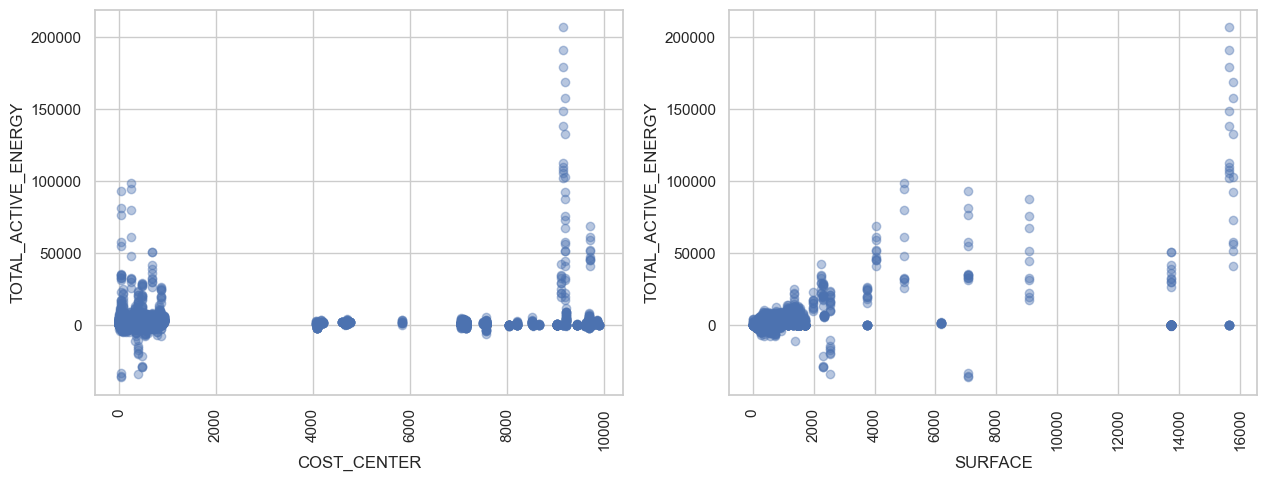

In [433]:
# scatter plots for numerical data
fig, axs = plt.subplots(nrows =1, ncols = 2, figsize = (15,5))

for i, col_name in enumerate(cols):
    row = i//2
    col = i%2
    axs[col].scatter(consumption_data[col_name], consumption_data['TOTAL_ACTIVE_ENERGY'], alpha = 0.4)
    axs[col].set_xlabel(col_name)
    axs[col].set_ylabel('TOTAL_ACTIVE_ENERGY')
    axs[col].tick_params(axis='x', labelrotation=90)
plt.show()
fig.savefig('scatter_plots')


**Conclusions from the scatter plots:**<br>
1)Understandably there is a clear directly proportional realtionship between surface area and total energy consumption.<br>
2)Cost center doesn't convey clear relationship with total energy consumption.

In [434]:
#Summing up the energy consumptions by year and month.
groupby_year_month = consumption_data.groupby(['YEAR', 'MONTH'], as_index=False)[['TOTAL_ACTIVE_ENERGY','F1_ACTIVE_ENERGY', 'F2_ACTIVE_ENERGY', 'F3_ACTIVE_ENERGY']].mean()

groupby_year_month 


YEAR  MONTH  TOTAL_ACTIVE_ENERGY  F1_ACTIVE_ENERGY  F2_ACTIVE_ENERGY  \
0   2021      1           266.500000        140.125000         14.750000   
1   2021      2           260.833333        159.166667         18.833333   
2   2021      3         -1111.875000       -961.500000        -79.875000   
3   2021      4           117.500000         72.166667        -16.666667   
4   2021      5           -24.166667         22.333333        -45.666667   
5   2021      6            78.125000         90.000000        -18.750000   
6   2021      7           149.375000        133.625000         -2.500000   
7   2021      8            41.900000         16.800000         -3.300000   
8   2021      9           325.210526        235.684211         27.052632   
9   2021     10           229.281250        155.062500         19.406250   
10  2021     11          -355.050000         30.125000       -157.350000   
11  2021     12           104.292308        110.969231         -3.969231   
12  2022      1          3065.973865       1660.412655        478.475928   
13  2022      2          2633.412414       1501.173793        446.085517   
14  2022      3          2870.137063       1655.595804        482.923077   
15  2022      4          2218.726891       1097.903361        399.333333   
16  2022      5          2633.369253       1437.727011        448.294540   
17  2022      6          3444.190678       1979.146893        543.336158   
18  2022      7          3980.202263       2295.265912        648.322489   
19  2022      8          3750.994326       2128.154610        584.753191   
20  2022      9          2995.652299       1720.791667        497.244253   
21  2022     10          2301.159292       1193.064897        425.964602   

    F3_ACTIVE_ENERGY  
0         111.625000  
1          82.833333  
2         -70.500000  
3          62.000000  
4          -0.833333  
5           6.875000  
6          18.250000  
7          28.400000  
8          62.473684  
9          54.812500  
10       -227.825000  
11         -2.707692  
12        927.085282  
13        686.153103  
14        731.618182  
15        721.490196  
16        747.347701  
17        921.707627  
18       1036.613861  
19       1038.086525  
20        777.616379  
21        682.129794

C:\Users\Chintu\AppData\Local\Temp\ipykernel_3440\2455837620.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='MONTH', y='TOTAL_ACTIVE_ENERGY', data=groupby_year_month, palette = 'bright', alpha = 0.4,  ax=axs[row, col])
C:\Users\Chintu\AppData\Local\Temp\ipykernel_3440\2455837620.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='MONTH', y='TOTAL_ACTIVE_ENERGY', data=groupby_year_month, palette = 'bright', alpha = 0.4,  ax=axs[row, col])
C:\Users\Chintu\AppData\Local\Temp\ipykernel_3440\2455837620.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='MONTH', y='TOTAL_ACTIVE_ENERGY', data=groupby_year_month, palette = 'bright', alpha = 0.4,  ax=axs[row, col])
C:\Users\Chintu\AppData\Local\Temp\ipykernel_3440\2455837620.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='MONTH', y='TOTAL_ACTIV

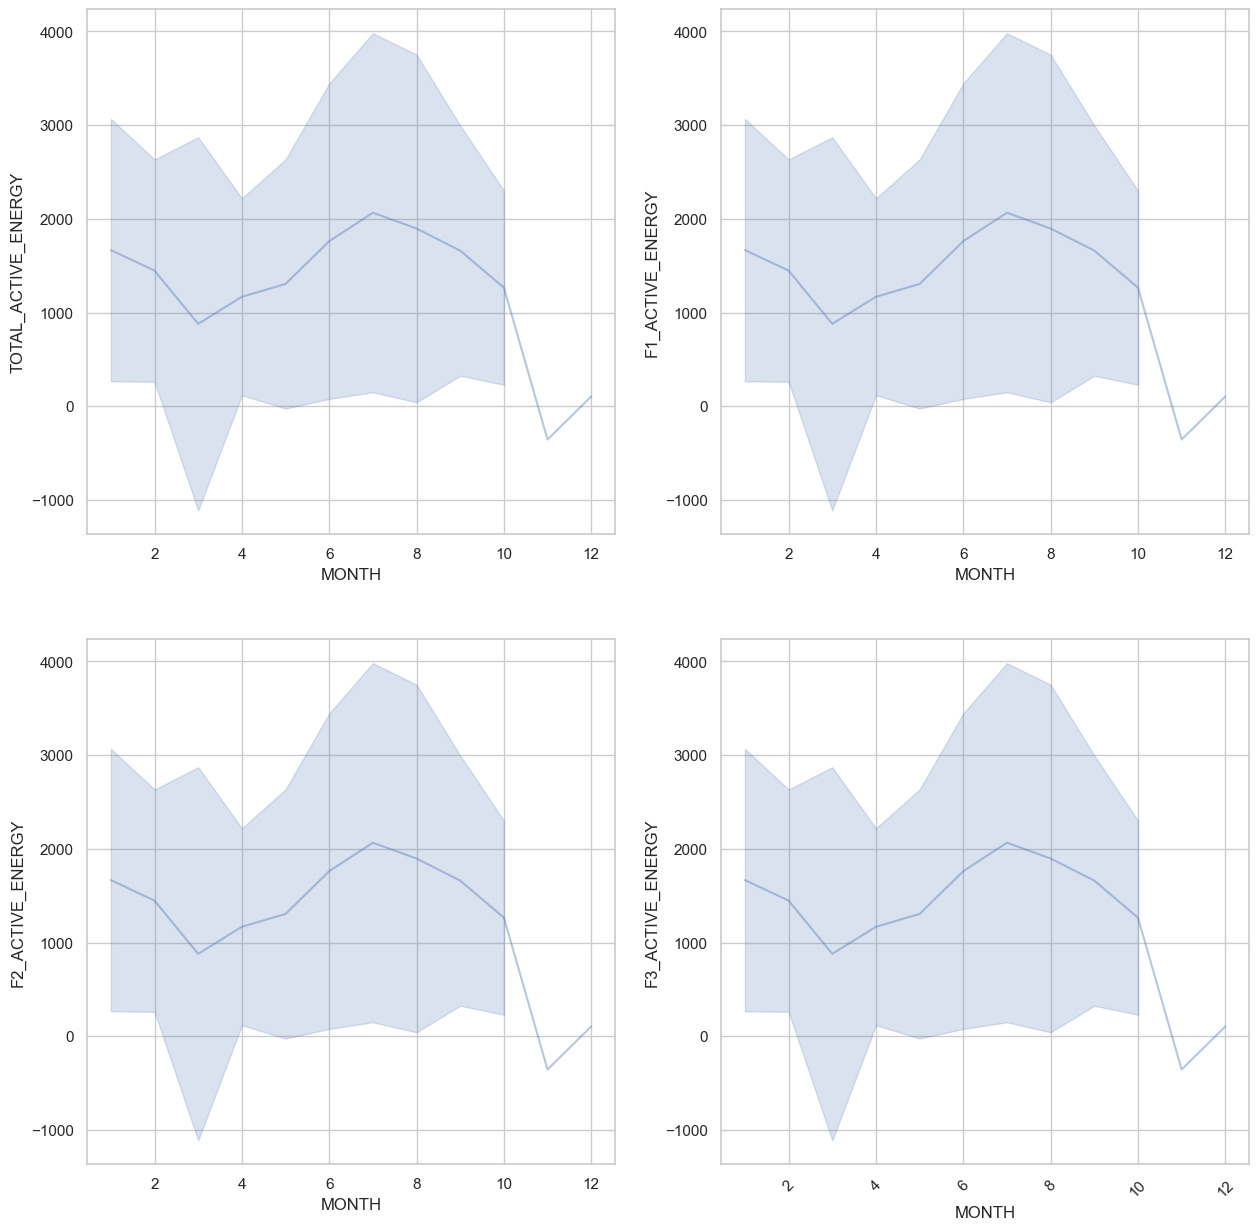

In [435]:
fig, axs = plt.subplots(nrows =2, ncols = 2, figsize = (15,15))
cols = ['TOTAL_ACTIVE_ENERGY','F1_ACTIVE_ENERGY', 'F2_ACTIVE_ENERGY', 'F3_ACTIVE_ENERGY']


for i, col_name in enumerate(cols):
    row = i//2
    col = i%2
    sns.lineplot(x='MONTH', y='TOTAL_ACTIVE_ENERGY', data=groupby_year_month, palette = 'bright', alpha = 0.4,  ax=axs[row, col])
    axs[row, col].set_xlabel('MONTH')
    axs[row, col].set_ylabel(col_name)
plt.xticks(rotation=45)
plt.show()
#fig.savefig('scatter_plots')


**Conclusions from lineplots:**<br>
1) Understandably, energy consumption is very high during the months of summer from june to August probably because of heavy usage of air conditioning.

In [437]:
consumption_data['DATA_TYPE']= consumption_data['DATA_TYPE'].astype('string')

### Looking at the data, I found some inconsistencies in the data. For the same POD meters, and in the same month and same year and same data_type, there are more than 1 consumption records but the consumption values are different. But clearly looking from the standpoint of the problem at hand, they have to be summed up to form a single record explaining the consumption in a particular year and month.

In [565]:
groupby_code_year_month_type = consumption_data.groupby(['POD','YEAR', 'MONTH', 'DATA_TYPE'], as_index=False)[['TOTAL_ACTIVE_ENERGY','F1_ACTIVE_ENERGY', 'F2_ACTIVE_ENERGY', 'F3_ACTIVE_ENERGY']].sum()

groupby_code_year_month_type

POD  YEAR  MONTH   DATA_TYPE  TOTAL_ACTIVE_ENERGY  \
0     IT001E00003923  2022      1       Reale                 3350   
1     IT001E00003923  2022      2       Reale                 2825   
2     IT001E00003923  2022      3       Reale                 3050   
3     IT001E00003923  2022      4       Reale                 2750   
4     IT001E00003923  2022      5       Reale                 2950   
...              ...   ...    ...         ...                  ...   
6875  IT221E00835179  2022      7       Reale                 2858   
6876  IT221E00835179  2022      8       Reale                 2419   
6877  IT221E00835179  2022      9  Conguaglio                 -404   
6878  IT221E00835179  2022      9     Stimato                 2106   
6879  IT221E00835179  2022     10  Conguaglio                 1758   

      F1_ACTIVE_ENERGY  F2_ACTIVE_ENERGY  F3_ACTIVE_ENERGY  
0                 1575               575              1200  
1                 1575               525               725  
2                 1775               550               725  
3                 1275               550               925  
4                 1400               575               975  
...                ...               ...               ...  
6875              1853               511               494  
6876              1508               389               522  
6877              -293               -31               -80  
6878              1252               365               489  
6879               991               345               422  

[6880 rows x 8 columns]

#### To the above grouped dataframe, all the remaining columns like building code, region, heating system etc have to be added. So, a merge operation will be performed.

In [567]:
consumption_data.columns

Index(['POD', 'YEAR', 'MONTH', 'DATA_TYPE', 'F1_ACTIVE_ENERGY',
       'F2_ACTIVE_ENERGY', 'F3_ACTIVE_ENERGY', 'TOTAL_ACTIVE_ENERGY',
       'COST_CENTER', 'BUILDING_CODE', 'SWITCH_TYPE', 'STATUS',
       'AGGREGATED_CODE', 'REGION', 'BUILDING_TYPE', 'HEATING_SYSTEM',
       'SURFACE'],
      dtype='object')

In [568]:
remaining_columns = consumption_data.drop(['YEAR', 'MONTH', 'DATA_TYPE', 'F1_ACTIVE_ENERGY',
       'F2_ACTIVE_ENERGY', 'F3_ACTIVE_ENERGY', 'TOTAL_ACTIVE_ENERGY','BUILDING_CODE','AGGREGATED_CODE'], axis=1)

remaining_columns

POD  COST_CENTER SWITCH_TYPE  STATUS          REGION  \
0     IT001E54998767       9024.0           1  ATTIVA  EMILIA-ROMAGNA   
1     IT001E54998767       9024.0           1  ATTIVA  EMILIA-ROMAGNA   
2     IT001E54998767       9024.0           1  ATTIVA  EMILIA-ROMAGNA   
3     IT001E54998767       9024.0           1  ATTIVA  EMILIA-ROMAGNA   
4     IT001E54998767       9024.0           1  ATTIVA  EMILIA-ROMAGNA   
...              ...          ...         ...     ...             ...   
7282  IT001E10923009       8203.0           1  ATTIVA  EMILIA-ROMAGNA   
7283  IT001E10923009       8203.0           1  ATTIVA  EMILIA-ROMAGNA   
7284  IT001E04436266       7103.0           1  ATTIVA         TOSCANA   
7285  IT001E04436266       7103.0           1  ATTIVA         TOSCANA   
7286  IT001E82640769       9702.0           3  ATTIVA        CAMPANIA   

        BUILDING_TYPE    HEATING_SYSTEM  SURFACE  
0     BRANCH OR STORE         HEAT PUMP   75.116  
1     BRANCH OR STORE         HEAT PUMP   75.116  
2     BRANCH OR STORE         HEAT PUMP   75.116  
3     BRANCH OR STORE         HEAT PUMP   75.116  
4     BRANCH OR STORE         HEAT PUMP   75.116  
...               ...               ...      ...  
7282  BRANCH OR STORE         HEAT PUMP   67.734  
7283  BRANCH OR STORE         HEAT PUMP   67.734  
7284  BRANCH OR STORE         HEAT PUMP   90.000  
7285  BRANCH OR STORE         HEAT PUMP   90.000  
7286      GUEST HOUSE  CALDAIA A METANO  100.000  

[7287 rows x 8 columns]

In [569]:
remaining_columns.drop_duplicates(inplace=True)
remaining_columns.reset_index(drop=True, inplace=True)

remaining_columns

POD  COST_CENTER SWITCH_TYPE  STATUS          REGION  \
0    IT001E54998767       9024.0           1  ATTIVA  EMILIA-ROMAGNA   
1    IT001E04018334        778.0           1  ATTIVA  EMILIA-ROMAGNA   
2    IT001E04018390       9024.0           1  ATTIVA  EMILIA-ROMAGNA   
3    IT001E04018401        675.0           1  ATTIVA  EMILIA-ROMAGNA   
4    IT001E04018383        674.0           1  ATTIVA  EMILIA-ROMAGNA   
..              ...          ...         ...     ...             ...   
674  IT001E04196473        200.0           1  ATTIVA         TOSCANA   
675  IT001E00006541        424.0           1  ATTIVA         SICILIA   
676  IT001E10923009       8203.0           1  ATTIVA  EMILIA-ROMAGNA   
677  IT001E04436266       7103.0           1  ATTIVA         TOSCANA   
678  IT001E82640769       9702.0           3  ATTIVA        CAMPANIA   

       BUILDING_TYPE    HEATING_SYSTEM  SURFACE  
0    BRANCH OR STORE         HEAT PUMP   75.116  
1    BRANCH OR STORE  CALDAIA A METANO  455.541  
2    BRANCH OR STORE           ASSENTE  126.995  
3    BRANCH OR STORE  CALDAIA A METANO  403.226  
4    BRANCH OR STORE  CALDAIA A METANO  408.329  
..               ...               ...      ...  
674  BRANCH OR STORE         HEAT PUMP   30.000  
675  BRANCH OR STORE         HEAT PUMP   80.000  
676  BRANCH OR STORE         HEAT PUMP   67.734  
677  BRANCH OR STORE         HEAT PUMP   90.000  
678      GUEST HOUSE  CALDAIA A METANO  100.000  

[679 rows x 8 columns]

In [570]:
groupby_code_year_month_type = remaining_columns.merge(groupby_code_year_month_type, how= 'left',on='POD')

groupby_code_year_month_type

POD  COST_CENTER SWITCH_TYPE  STATUS          REGION  \
0     IT001E54998767       9024.0           1  ATTIVA  EMILIA-ROMAGNA   
1     IT001E54998767       9024.0           1  ATTIVA  EMILIA-ROMAGNA   
2     IT001E54998767       9024.0           1  ATTIVA  EMILIA-ROMAGNA   
3     IT001E54998767       9024.0           1  ATTIVA  EMILIA-ROMAGNA   
4     IT001E54998767       9024.0           1  ATTIVA  EMILIA-ROMAGNA   
...              ...          ...         ...     ...             ...   
6875  IT001E10923009       8203.0           1  ATTIVA  EMILIA-ROMAGNA   
6876  IT001E10923009       8203.0           1  ATTIVA  EMILIA-ROMAGNA   
6877  IT001E04436266       7103.0           1  ATTIVA         TOSCANA   
6878  IT001E04436266       7103.0           1  ATTIVA         TOSCANA   
6879  IT001E82640769       9702.0           3  ATTIVA        CAMPANIA   

        BUILDING_TYPE    HEATING_SYSTEM  SURFACE  YEAR  MONTH DATA_TYPE  \
0     BRANCH OR STORE         HEAT PUMP   75.116  2022      1     Reale   
1     BRANCH OR STORE         HEAT PUMP   75.116  2022      2     Reale   
2     BRANCH OR STORE         HEAT PUMP   75.116  2022      3     Reale   
3     BRANCH OR STORE         HEAT PUMP   75.116  2022      4     Reale   
4     BRANCH OR STORE         HEAT PUMP   75.116  2022      5     Reale   
...               ...               ...      ...   ...    ...       ...   
6875  BRANCH OR STORE         HEAT PUMP   67.734  2022      9     Reale   
6876  BRANCH OR STORE         HEAT PUMP   67.734  2022     10     Reale   
6877  BRANCH OR STORE         HEAT PUMP   90.000  2022      9     Reale   
6878  BRANCH OR STORE         HEAT PUMP   90.000  2022     10     Reale   
6879      GUEST HOUSE  CALDAIA A METANO  100.000  2022     10     Reale   

      TOTAL_ACTIVE_ENERGY  F1_ACTIVE_ENERGY  F2_ACTIVE_ENERGY  \
0                     515               142               114   
1                     458               140               113   
2                     496               156               123   
3                     474               126               117   
4                     495               151               119   
...                   ...               ...               ...   
6875                   14                14                 0   
6876                   16                 9                 3   
6877                    0                 0                 0   
6878                    0                 0                 0   
6879                   25                 8                 9   

      F3_ACTIVE_ENERGY  
0                  259  
1                  205  
2                  217  
3                  231  
4                  225  
...                ...  
6875                 0  
6876                 4  
6877                 0  
6878                 0  
6879                 8  

[6880 rows x 15 columns]

In [571]:
groupby_code_year_month_type.drop('POD', axis=1, inplace=True)

### From the standpoint of business, conguaglio datatype is just the un accounted consumptions in the past months. It cannot be used directly to forecast monthly consumptions. So, it's better to drop all the records where DATA_TYPE is conguaglio.

In [572]:
groupby_code_year_month_type = groupby_code_year_month_type[groupby_code_year_month_type['DATA_TYPE'] != 'Conguaglio']
groupby_code_year_month_type

COST_CENTER SWITCH_TYPE  STATUS          REGION    BUILDING_TYPE  \
0          9024.0           1  ATTIVA  EMILIA-ROMAGNA  BRANCH OR STORE   
1          9024.0           1  ATTIVA  EMILIA-ROMAGNA  BRANCH OR STORE   
2          9024.0           1  ATTIVA  EMILIA-ROMAGNA  BRANCH OR STORE   
3          9024.0           1  ATTIVA  EMILIA-ROMAGNA  BRANCH OR STORE   
4          9024.0           1  ATTIVA  EMILIA-ROMAGNA  BRANCH OR STORE   
...           ...         ...     ...             ...              ...   
6875       8203.0           1  ATTIVA  EMILIA-ROMAGNA  BRANCH OR STORE   
6876       8203.0           1  ATTIVA  EMILIA-ROMAGNA  BRANCH OR STORE   
6877       7103.0           1  ATTIVA         TOSCANA  BRANCH OR STORE   
6878       7103.0           1  ATTIVA         TOSCANA  BRANCH OR STORE   
6879       9702.0           3  ATTIVA        CAMPANIA      GUEST HOUSE   

        HEATING_SYSTEM  SURFACE  YEAR  MONTH DATA_TYPE  TOTAL_ACTIVE_ENERGY  \
0            HEAT PUMP   75.116  2022      1     Reale                  515   
1            HEAT PUMP   75.116  2022      2     Reale                  458   
2            HEAT PUMP   75.116  2022      3     Reale                  496   
3            HEAT PUMP   75.116  2022      4     Reale                  474   
4            HEAT PUMP   75.116  2022      5     Reale                  495   
...                ...      ...   ...    ...       ...                  ...   
6875         HEAT PUMP   67.734  2022      9     Reale                   14   
6876         HEAT PUMP   67.734  2022     10     Reale                   16   
6877         HEAT PUMP   90.000  2022      9     Reale                    0   
6878         HEAT PUMP   90.000  2022     10     Reale                    0   
6879  CALDAIA A METANO  100.000  2022     10     Reale                   25   

      F1_ACTIVE_ENERGY  F2_ACTIVE_ENERGY  F3_ACTIVE_ENERGY  
0                  142               114               259  
1                  140               113               205  
2                  156               123               217  
3                  126               117               231  
4                  151               119               225  
...                ...               ...               ...  
6875                14                 0                 0  
6876                 9                 3                 4  
6877                 0                 0                 0  
6878                 0                 0                 0  
6879                 8                 9                 8  

[6769 rows x 14 columns]

In [573]:
check_columns(groupby_code_year_month_type)

column    shape  datatype  unique_values  null_values  \
0           COST_CENTER  (6769,)   float64          False        False   
1           SWITCH_TYPE  (6769,)  category          False        False   
2                STATUS  (6769,)  category          False        False   
3                REGION  (6769,)  category          False        False   
4         BUILDING_TYPE  (6769,)  category          False        False   
5        HEATING_SYSTEM  (6769,)  category          False        False   
6               SURFACE  (6769,)   float64          False        False   
7                  YEAR  (6769,)     int64          False        False   
8                 MONTH  (6769,)     int64          False        False   
9             DATA_TYPE  (6769,)    string          False        False   
10  TOTAL_ACTIVE_ENERGY  (6769,)     int64          False        False   
11     F1_ACTIVE_ENERGY  (6769,)     int64          False        False   
12     F2_ACTIVE_ENERGY  (6769,)     int64          False        False   
13     F3_ACTIVE_ENERGY  (6769,)     int64          False        False   

    null_count  nunique  
0            0      547  
1            0        7  
2            0        2  
3            0       19  
4            0        4  
5            0        8  
6            0      608  
7            0        2  
8            0       12  
9            0        2  
10           0     3831  
11           0     3044  
12           0     1318  
13           0     1762

In [574]:
# converting datatypes

groupby_code_year_month_type[['YEAR', 'MONTH', 'DATA_TYPE']]= groupby_code_year_month_type[['YEAR', 'MONTH','DATA_TYPE']].astype('category')


C:\Users\Chintu\AppData\Local\Temp\ipykernel_3440\309751240.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  groupby_code_year_month_type[['YEAR', 'MONTH', 'DATA_TYPE']]= groupby_code_year_month_type[['YEAR', 'MONTH','DATA_TYPE']].astype('category')


In [575]:
groupby_code_year_month_type['BUILDING_TYPE'].value_counts()

BRANCH OR STORE             6268
GUEST HOUSE                  262
OFFICES                      199
OTHER                         40
NEVER ACTIVATE UTILITIES       0
Name: BUILDING_TYPE, dtype: int64

In [576]:
groupby_code_year_month_type = groupby_code_year_month_type.drop(groupby_code_year_month_type[groupby_code_year_month_type['BUILDING_TYPE']== 'NEVER_ACTIVATE_UTILITIES'].index)

In [577]:
groupby_code_year_month_type['DATA_TYPE'].value_counts()

Reale      6552
Stimato     217
Name: DATA_TYPE, dtype: int64

In [578]:
columns = ['SWITCH_TYPE','YEAR','MONTH','STATUS','REGION', 'BUILDING_TYPE', 'HEATING_SYSTEM', 'DATA_TYPE']

final_consumption_dummies = pd.get_dummies(groupby_code_year_month_type[columns])

final_consumption_dataframe = pd.concat([final_consumption_dummies, groupby_code_year_month_type[['COST_CENTER', 'SURFACE','F1_ACTIVE_ENERGY',
       'F2_ACTIVE_ENERGY', 'F3_ACTIVE_ENERGY', 'TOTAL_ACTIVE_ENERGY']]], axis=1)

final_consumption_dataframe

SWITCH_TYPE_0  SWITCH_TYPE_1  SWITCH_TYPE_2  SWITCH_TYPE_3  \
0                 0              1              0              0   
1                 0              1              0              0   
2                 0              1              0              0   
3                 0              1              0              0   
4                 0              1              0              0   
...             ...            ...            ...            ...   
6875              0              1              0              0   
6876              0              1              0              0   
6877              0              1              0              0   
6878              0              1              0              0   
6879              0              0              0              1   

      SWITCH_TYPE_4  SWITCH_TYPE_5  SWITCH_TYPE_6  YEAR_2021  YEAR_2022  \
0                 0              0              0          0          1   
1                 0              0              0          0          1   
2                 0              0              0          0          1   
3                 0              0              0          0          1   
4                 0              0              0          0          1   
...             ...            ...            ...        ...        ...   
6875              0              0              0          0          1   
6876              0              0              0          0          1   
6877              0              0              0          0          1   
6878              0              0              0          0          1   
6879              0              0              0          0          1   

      MONTH_1  ...  HEATING_SYSTEM_TELERISCALDAMENTO  \
0           1  ...                                 0   
1           0  ...                                 0   
2           0  ...                                 0   
3           0  ...                                 0   
4           0  ...                                 0   
...       ...  ...                               ...   
6875        0  ...                                 0   
6876        0  ...                                 0   
6877        0  ...                                 0   
6878        0  ...                                 0   
6879        0  ...                                 0   

      HEATING_SYSTEM_TELERISCLDAMENTO  DATA_TYPE_Reale  DATA_TYPE_Stimato  \
0                                   0                1                  0   
1                                   0                1                  0   
2                                   0                1                  0   
3                                   0                1                  0   
4                                   0                1                  0   
...                               ...              ...                ...   
6875                                0                1                  0   
6876                                0                1                  0   
6877                                0                1                  0   
6878                                0                1                  0   
6879                                0                1                  0   

      COST_CENTER  SURFACE  F1_ACTIVE_ENERGY  F2_ACTIVE_ENERGY  \
0          9024.0   75.116               142               114   
1          9024.0   75.116               140               113   
2          9024.0   75.116               156               123   
3          9024.0   75.116               126               117   
4          9024.0   75.116               151               119   
...           ...      ...               ...               ...   
6875       8203.0   67.734                14                 0   
6876       8203.0   67.734                 9                 3   
6877       7103.0   90.000                 0                 0   
6878       7103.0   90.000    

C:\Users\Chintu\AppData\Local\Temp\ipykernel_3440\461705526.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_consumption_dataframe[col_name], ax=axs[col])
C:\Users\Chintu\AppData\Local\Temp\ipykernel_3440\461705526.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_consumption_da

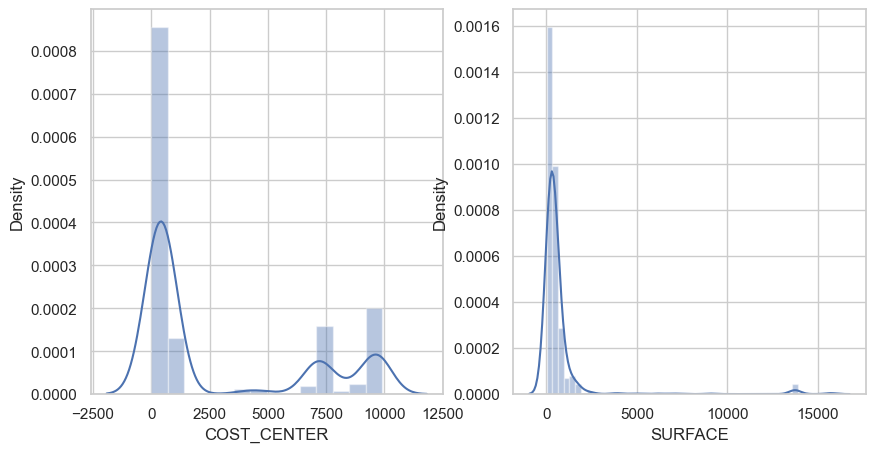

In [579]:
# Distribution plots of numerical plots
fig, axs = plt.subplots(nrows =1, ncols = 2, figsize = (10,5))
cols = ['COST_CENTER', 'SURFACE']

for i, col_name in enumerate(cols):
    col = i%2
    sns.distplot(final_consumption_dataframe[col_name], ax=axs[col])
    axs[col].set_xlabel(col_name)
fig.savefig('dist_plots')
plt.show()


### Distribution plot of cost center looks bimodal probably due to absence normal with long tails. Need some transormations to be performed.

## Applying Log transformation

C:\Users\Chintu\AppData\Local\Temp\ipykernel_3440\1858130688.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(final_consumption_dataframe[col_name]), ax=axs[col])
C:\Users\Chintu\AppData\Local\Temp\ipykernel_3440\1858130688.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(fin

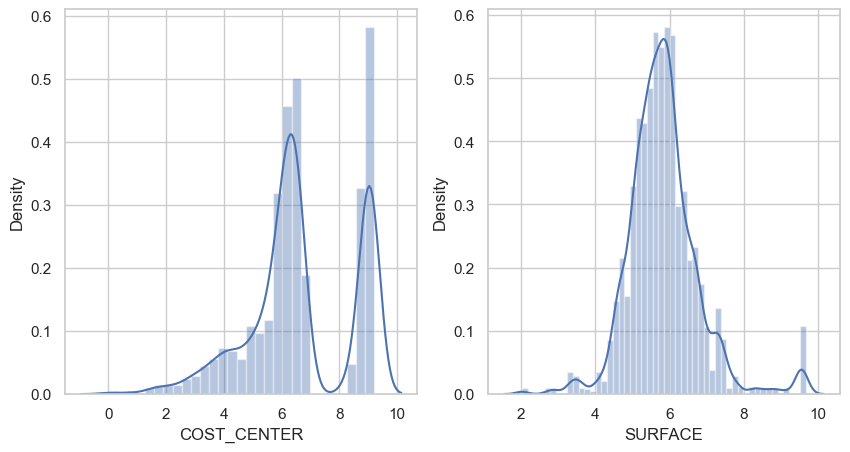

In [482]:
# Distribution plots of numerical plots
fig, axs = plt.subplots(nrows =1, ncols = 2, figsize = (10,5))
cols = ['COST_CENTER', 'SURFACE']

for i, col_name in enumerate(cols):
    col = i%2
    sns.distplot(np.log(final_consumption_dataframe[col_name]), ax=axs[col])
    axs[col].set_xlabel(col_name)
fig.savefig('dist_plots')
plt.show()


### Now each graph looks bimodal and normal respectively. Evidently from the distribution plot, there are some outliers in the SURFACE varaiable. But it includes some important consumption information of buildings which has more surface area which cannot be discarded as outliers. So, to overcome this problem, tree based models(Random forest or XGBoost) which are robust against outliers can be used. Also tree based methods are independent of feature scales and hence eliminating the necessity of using standard scaler or minmax scaler on the data. Hence I decided to use XGBoost algorithm for this project.

In [506]:
final_consumption_dataframe[['COST_CENTER', 'SURFACE']] = np.log(final_consumption_dataframe[['COST_CENTER', 'SURFACE']])

(array([1, 2]), [Text(1, 0, 'COST_CENTER'), Text(2, 0, 'SURFACE')])

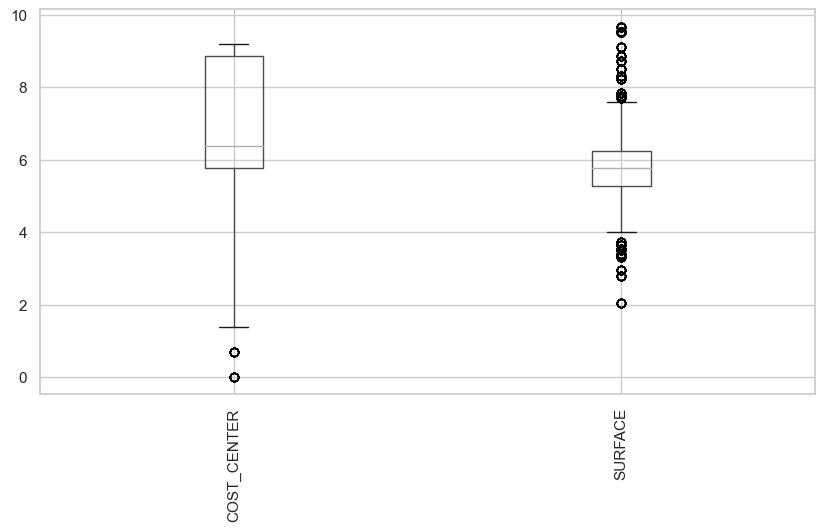

In [507]:
# Cross checking for outliers using boxplots
fig, axs = plt.subplots(figsize = (10,5))
ax = final_consumption_dataframe[[ 'COST_CENTER', 'SURFACE']].boxplot()
 
plt.xticks(rotation=90)



In [508]:
final_consumption_dataframe.iloc[:, :-4]

SWITCH_TYPE_0  SWITCH_TYPE_1  SWITCH_TYPE_2  SWITCH_TYPE_3  \
0                 0              1              0              0   
1                 0              1              0              0   
2                 0              1              0              0   
3                 0              1              0              0   
4                 0              1              0              0   
...             ...            ...            ...            ...   
6875              0              1              0              0   
6876              0              1              0              0   
6877              0              1              0              0   
6878              0              1              0              0   
6879              0              0              0              1   

      SWITCH_TYPE_4  SWITCH_TYPE_5  SWITCH_TYPE_6  YEAR_2021  YEAR_2022  \
0                 0              0              0          0          1   
1                 0              0              0          0          1   
2                 0              0              0          0          1   
3                 0              0              0          0          1   
4                 0              0              0          0          1   
...             ...            ...            ...        ...        ...   
6875              0              0              0          0          1   
6876              0              0              0          0          1   
6877              0              0              0          0          1   
6878              0              0              0          0          1   
6879              0              0              0          0          1   

      MONTH_1  ...  HEATING_SYSTEM_CONDOMINIALE+HEAT PUMP  \
0           1  ...                                      0   
1           0  ...                                      0   
2           0  ...                                      0   
3           0  ...                                      0   
4           0  ...                                      0   
...       ...  ...                                    ...   
6875        0  ...                                      0   
6876        0  ...                                      0   
6877        0  ...                                      0   
6878        0  ...                                      0   
6879        0  ...                                      0   

      HEATING_SYSTEM_HEAT PUMP  HEATING_SYSTEM_HEAT PUMP + CALDAIA A METANO  \
0                            1                                            0   
1                            1                                            0   
2                            1                                            0   
3                            1                                            0   
4                            1                                            0   
...                        ...                                          ...   
6875                         1                                            0   
6876                         1                                            0   
6877                         1                                            0   
6878                         1                                            0   
6879                         0                                            0   

      HEATING_SYSTEM_TELERISCALDAMENTO  HEATING_SYSTEM_TELERISCLDAMENTO  \
0                                    0                                0   
1                                    0                                0   
2                                    0                                0   
3                                    0                                0   
4                                    0                                0   
...                                ...                              ...   
6875                                 0                                0   
6876  

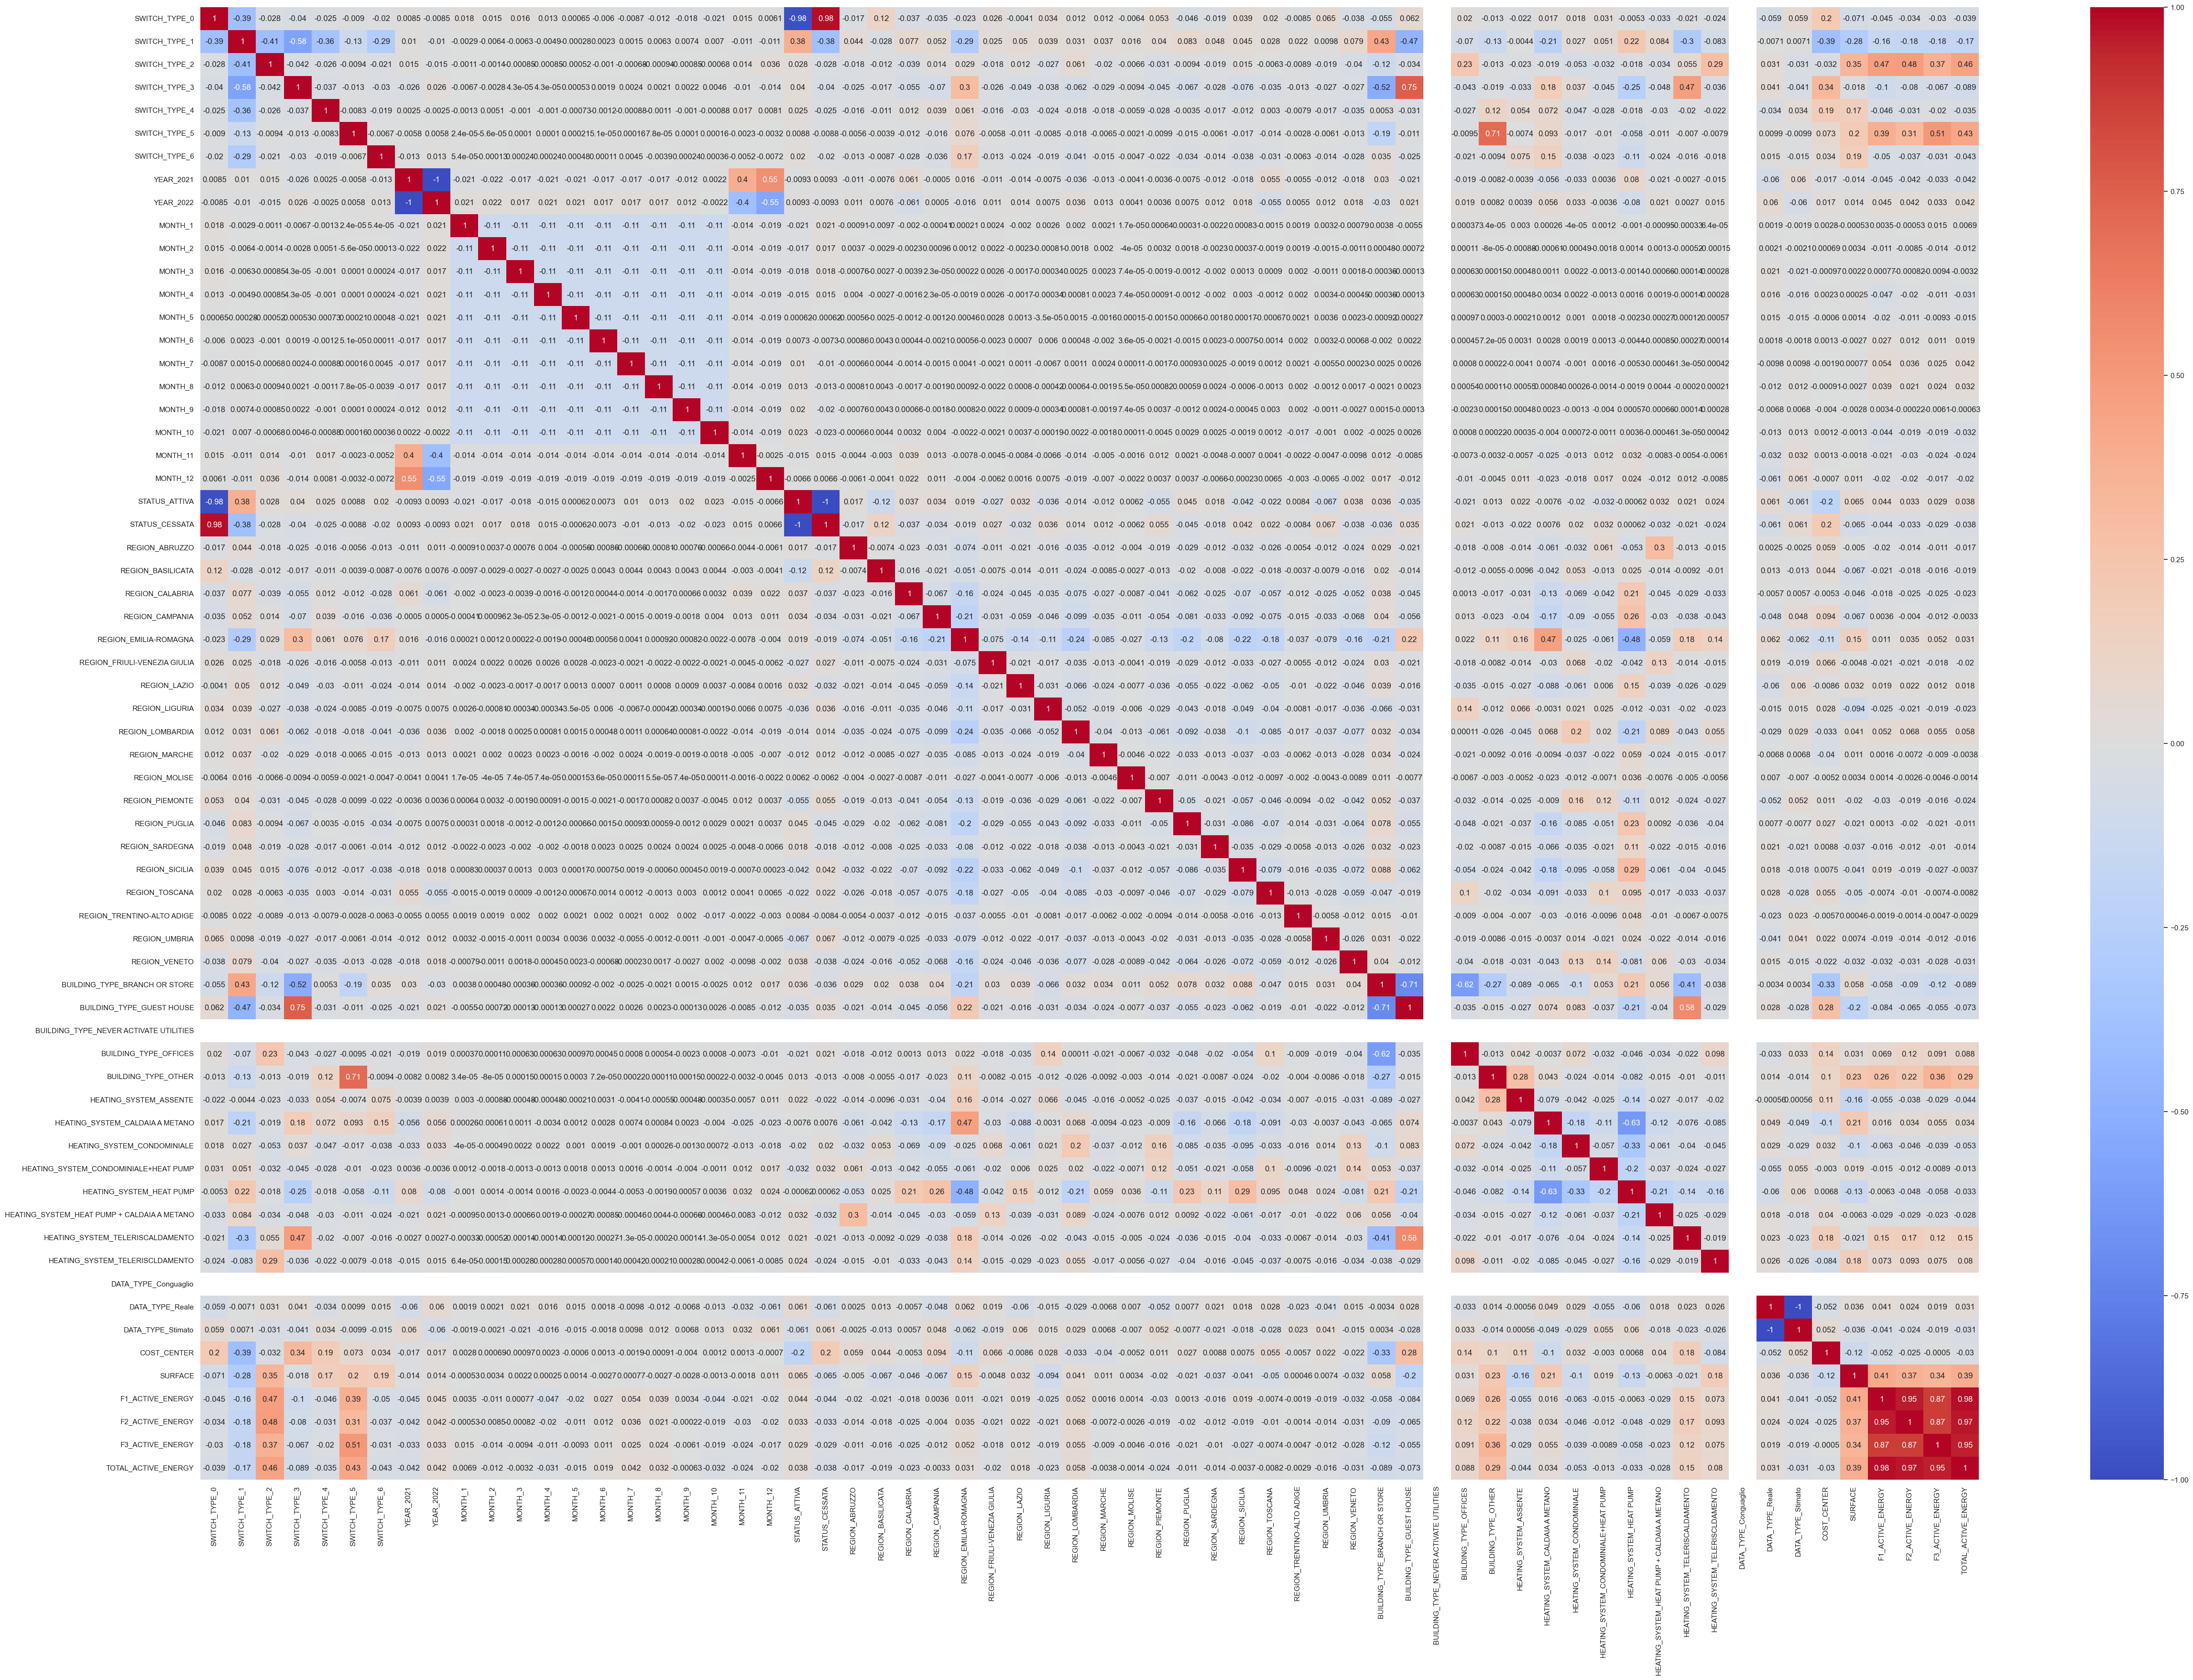

In [509]:
corr = final_consumption_dataframe.corr()
plt.figure(figsize=(60,40))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.savefig("correlation.png")

## From the correlation heat map above highly correlated columns will be dropped below

In [510]:
final_consumption_dataframe.drop(['STATUS_ATTIVA', 'STATUS_CESSATA', 'BUILDING_TYPE_GUEST HOUSE', 'BUILDING_TYPE_NEVER ACTIVATE UTILITIES', 'DATA_TYPE_Conguaglio', 'DATA_TYPE_Stimato', 'BUILDING_TYPE_OTHER', 'YEAR_2021'], axis=1, inplace=True)
final_consumption_dataframe

SWITCH_TYPE_0  SWITCH_TYPE_1  SWITCH_TYPE_2  SWITCH_TYPE_3  \
0                 0              1              0              0   
1                 0              1              0              0   
2                 0              1              0              0   
3                 0              1              0              0   
4                 0              1              0              0   
...             ...            ...            ...            ...   
6875              0              1              0              0   
6876              0              1              0              0   
6877              0              1              0              0   
6878              0              1              0              0   
6879              0              0              0              1   

      SWITCH_TYPE_4  SWITCH_TYPE_5  SWITCH_TYPE_6  YEAR_2022  MONTH_1  \
0                 0              0              0          1        1   
1                 0              0              0          1        0   
2                 0              0              0          1        0   
3                 0              0              0          1        0   
4                 0              0              0          1        0   
...             ...            ...            ...        ...      ...   
6875              0              0              0          1        0   
6876              0              0              0          1        0   
6877              0              0              0          1        0   
6878              0              0              0          1        0   
6879              0              0              0          1        0   

      MONTH_2  ...  HEATING_SYSTEM_HEAT PUMP + CALDAIA A METANO  \
0           0  ...                                            0   
1           1  ...                                            0   
2           0  ...                                            0   
3           0  ...                                            0   
4           0  ...                                            0   
...       ...  ...                                          ...   
6875        0  ...                                            0   
6876        0  ...                                            0   
6877        0  ...                                            0   
6878        0  ...                                            0   
6879        0  ...                                            0   

      HEATING_SYSTEM_TELERISCALDAMENTO  HEATING_SYSTEM_TELERISCLDAMENTO  \
0                                    0                                0   
1                                    0                                0   
2                                    0                                0   
3                                    0                                0   
4                                    0                                0   
...                                ...                              ...   
6875                                 0                                0   
6876                                 0                                0   
6877                                 0                                0   
6878                                 0                                0   
6879                                 0                                0   

      DATA_TYPE_Reale  COST_CENTER   SURFACE  F1_ACTIVE_ENERGY  \
0                   1     9.107643  4.319034               142   
1                   1     9.107643  4.319034               140   
2                   1     9.107643  4.319034               156   
3                   1     9.107643  4.319034               126   
4                   1     9.107643  4.319034               151   
...               ...          ...       ...               ...   
6875                1     9.012255  4.215588                14   
6876                1     9.012255  4.215588                 9   
6877        

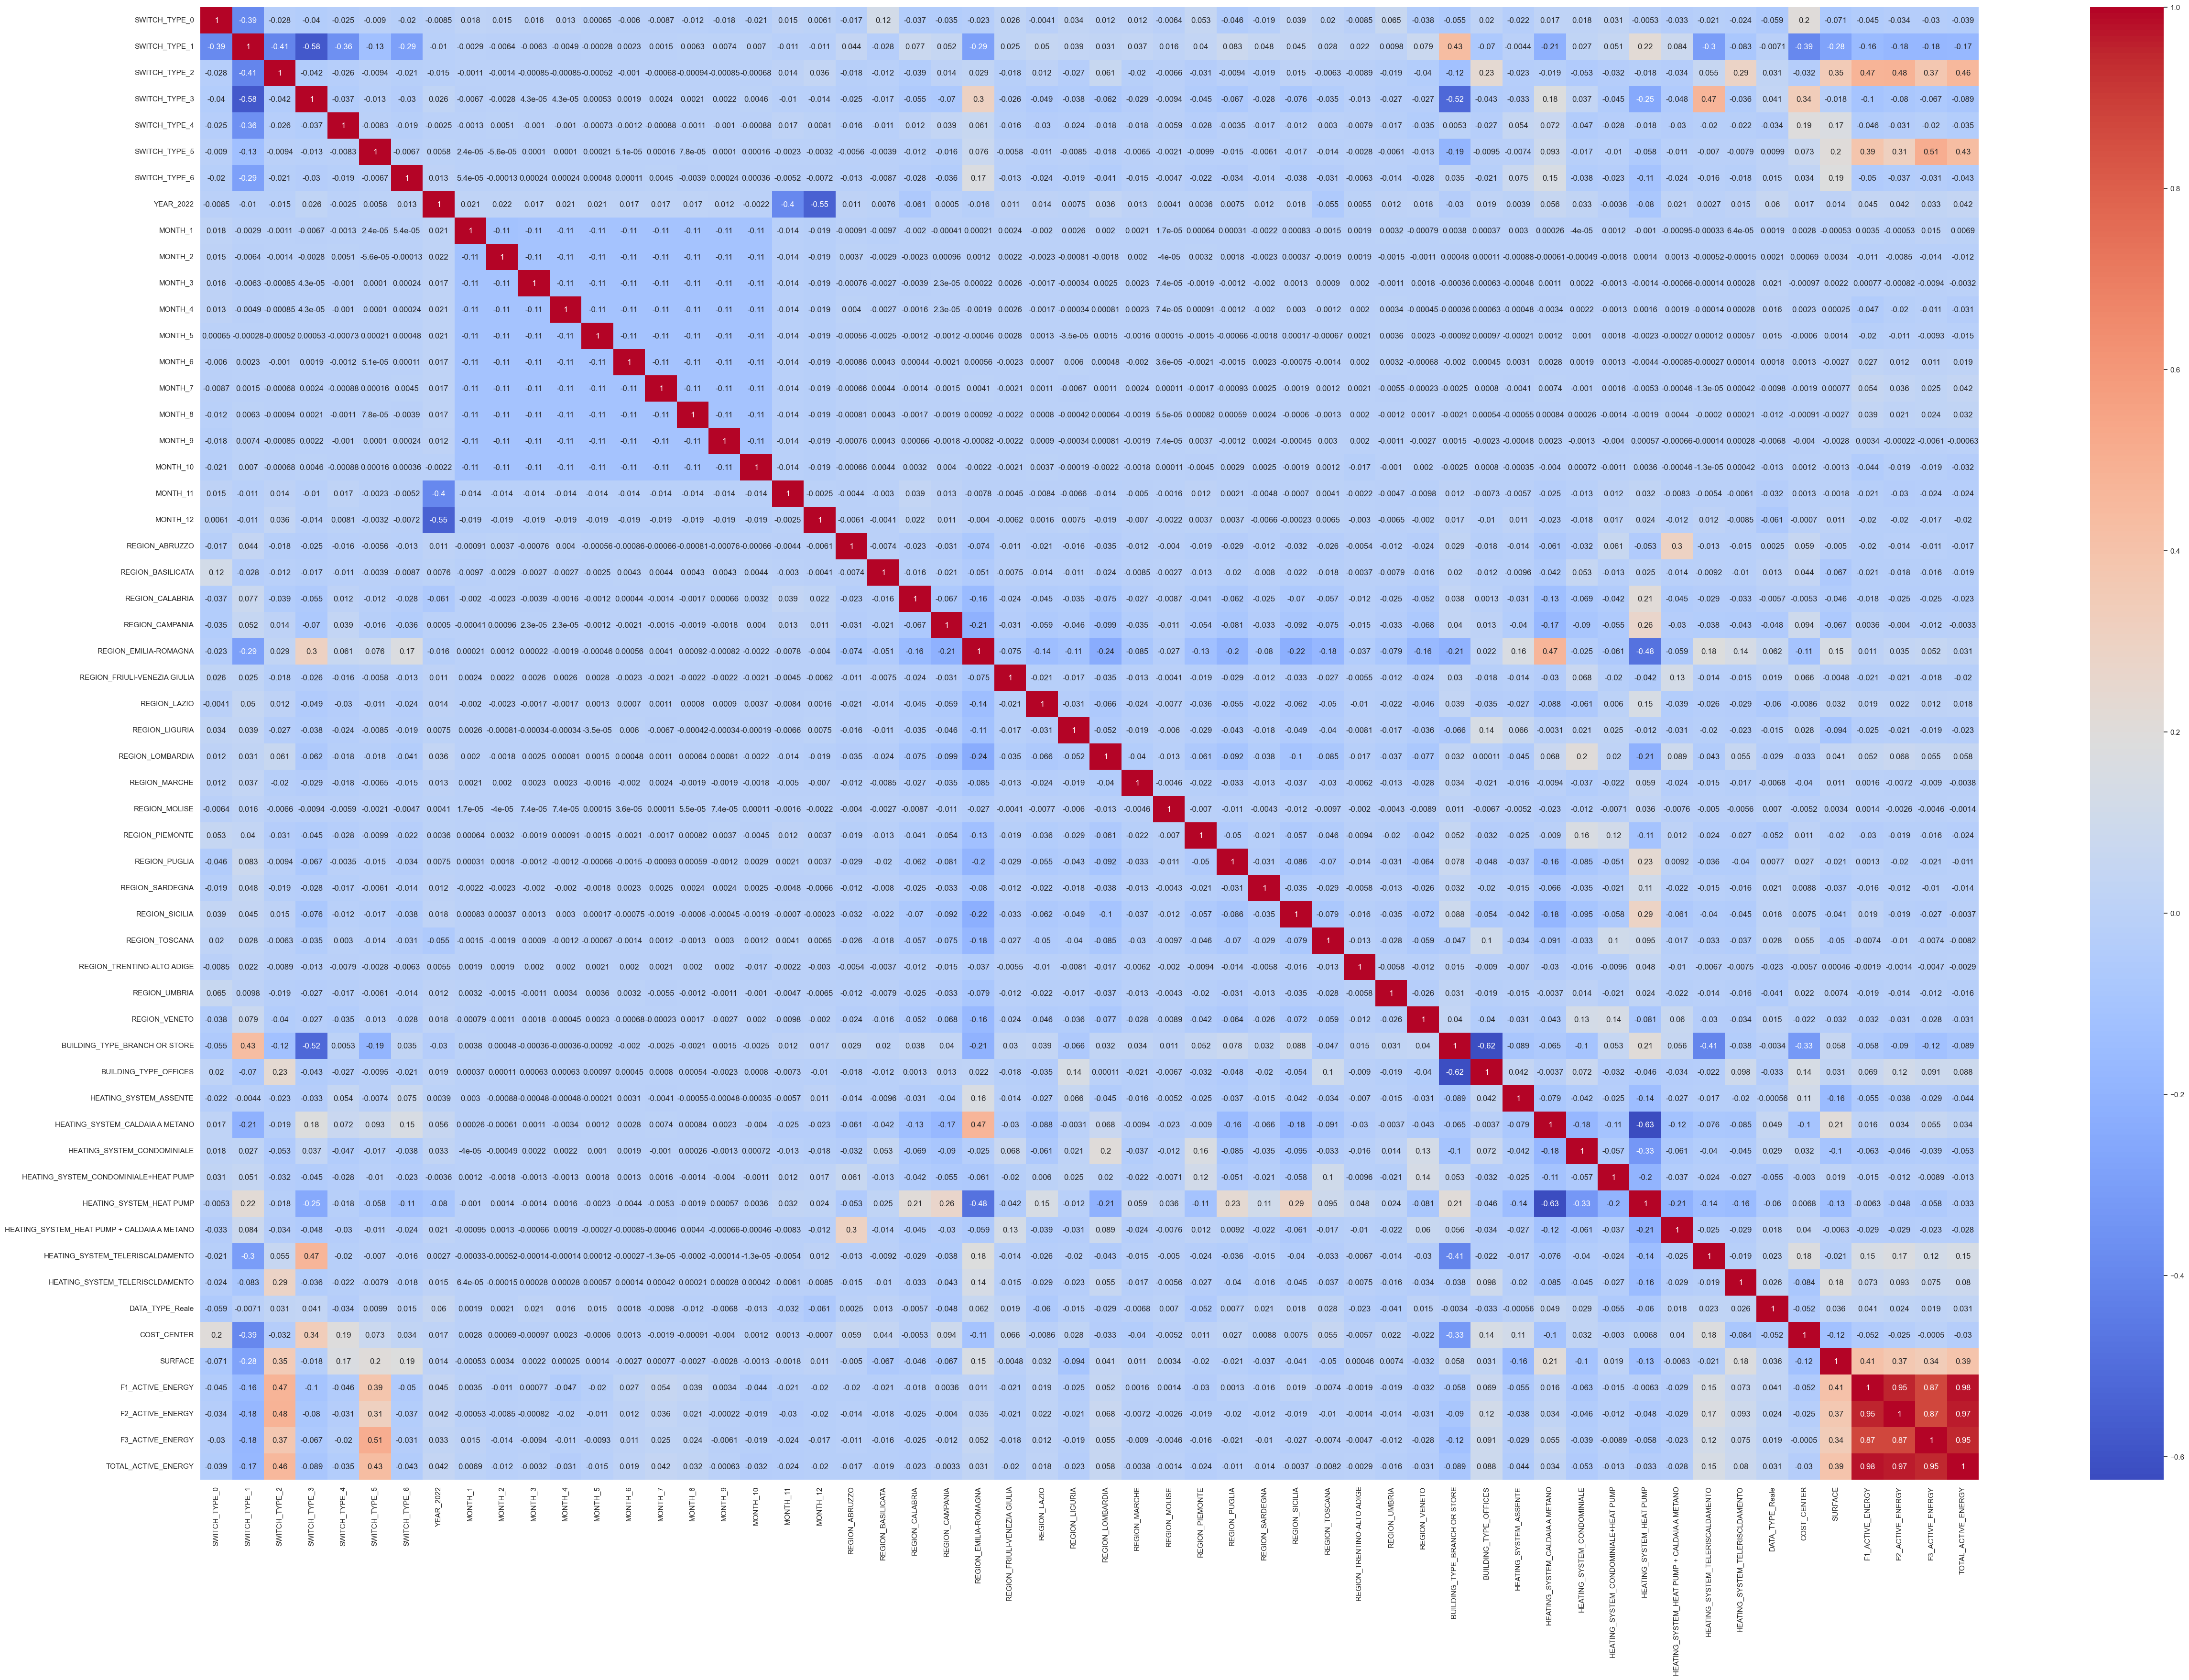

In [511]:
corr = final_consumption_dataframe.corr()
plt.figure(figsize=(60,40))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.savefig("correlation.png")

# Model Building

### Total active consumption is just the sum of F1, F2, F3 consumptions. It is enough to just predict those 3 consumptions independently and summing up those predictions to predict total consumption. Hence 3 different models one for each F1, F2, F3 are built below.

In [512]:
# Test train split
X = final_consumption_dataframe.iloc[:, :-4]
y = final_consumption_dataframe['F1_ACTIVE_ENERGY']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [513]:
# Define the model
model_xg = XGBRegressor()

In [514]:
params={
 "learning_rate"    : [0.01, 0.10, 0.20, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3 ],
 "colsample_bytree" : [ 0.3, 0.5 , 0.7 ]
    
}

In [515]:
# Define the cross-validation method
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define the GridSearchCV object
grid_search = GridSearchCV(model_xg, params, cv=kf, scoring='r2', n_jobs=-1)



In [516]:
# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    int...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                 

In [517]:
# Print the best hyperparameters and the corresponding R-squared score
print("Best parameters: ", grid_search.best_params_)
print("Best R-squared score: ", grid_search.best_score_)



Best parameters:  {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3}
Best R-squared score:  0.8609539640399981


In [518]:
# Extract the best model and use it to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


In [519]:
r2 = r2_score(y_test, y_pred)
r2

0.8028572982354046

In [520]:

# Calculate the R-squared score on the test data
pred = best_model.score(X_test, y_test)
print("Testing R-squared score: ", pred)

Testing R-squared score:  0.8028572982354046


In [521]:
importance_scores = best_model.feature_importances_
importance_scores

array([9.5233187e-04, 3.0647952e-03, 2.3179170e-01, 3.1753812e-02,
       2.7865400e-03, 1.7041506e-01, 5.6061256e-03, 4.0290210e-02,
       4.2346707e-03, 3.6486823e-03, 9.2418836e-03, 1.3957745e-02,
       5.3212051e-03, 1.8818494e-02, 1.2855906e-02, 5.2856258e-03,
       5.5921511e-03, 8.7913359e-03, 9.6275227e-04, 1.7092159e-02,
       8.0987834e-04, 1.2233016e-03, 1.0001068e-03, 1.9886286e-03,
       9.9668661e-03, 3.9887527e-04, 4.5119217e-03, 3.7704140e-04,
       1.6447310e-03, 1.3350019e-03, 4.6357167e-05, 2.7624466e-03,
       1.2630509e-03, 2.8238457e-04, 6.2629511e-03, 2.7462728e-03,
       0.0000000e+00, 2.2846893e-03, 7.8774133e-04, 2.9849555e-02,
       1.6293564e-03, 1.7075235e-03, 2.0031605e-02, 8.8428048e-04,
       1.2542738e-03, 6.6235345e-03, 1.7546503e-03, 1.9921650e-01,
       8.1770793e-03, 2.4715278e-03, 1.0840794e-02, 8.3403818e-02],
      dtype=float32)

In [522]:
# Model errors for test

mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)

print("MSE on test data: ", mse_test)
print("MAE on test data: ", mae_test)

MSE on test data:  4299313.950640832
MAE on test data:  526.904439748302


In [524]:
y_pred_tr= best_model.predict(X_train)

In [525]:
# Model errors for train

mse_train = mean_squared_error(y_train, y_pred_tr)
mae_train = mean_absolute_error(y_train, y_pred_tr)

print("MSE on test data: ", mse_train)
print("MAE on test data: ", mae_train)

MSE on test data:  390925.51584094355
MAE on test data:  354.3137349863517


In [526]:
final_consumption_dataframe['F1_ACTIVE_ENERGY'].describe()

count      6769.000000
mean       1737.329148
std        4087.374647
min       -8537.000000
25%         459.000000
50%        1144.000000
75%        1981.000000
max      111422.000000
Name: F1_ACTIVE_ENERGY, dtype: float64

In [527]:
error_1 = y_test-y_pred

In [528]:
error_1.describe()

count     1354.000000
mean        45.805901
std       2073.738613
min     -11099.941406
25%       -280.306671
50%        -13.265533
75%        233.219559
max      54069.257812
Name: F1_ACTIVE_ENERGY, dtype: float64

C:\Users\Chintu\AppData\Local\Temp\ipykernel_3440\1244368212.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error_1)


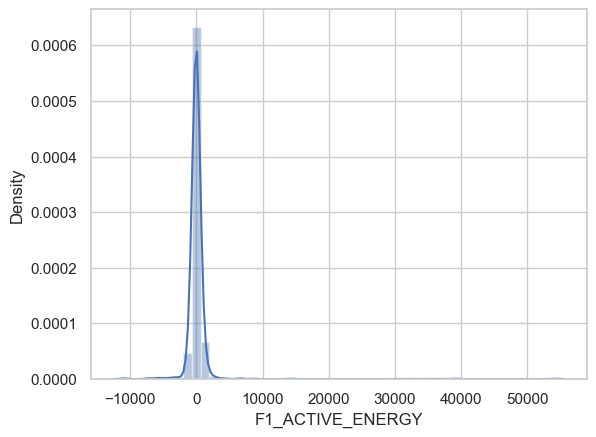

In [529]:
sns.distplot(error_1)
plt.show()

## Model for F2_ACTIVE_ENERGY

In [530]:
# Define the model
model_f_2 = XGBRegressor()

In [531]:
# Define the GridSearchCV object
grid_search_f2 = GridSearchCV(model_f_2, params, cv=kf, scoring='r2', n_jobs=-1)

In [532]:
X_f2 = final_consumption_dataframe.iloc[:, :-4]
y_f2 = final_consumption_dataframe['F2_ACTIVE_ENERGY']
X_train_f2, X_test_f2, y_train_f2, y_test_f2 = train_test_split(X_f2, y_f2, test_size=0.2, random_state=42)

In [533]:
# Fit the GridSearchCV object to the data
grid_search_f2.fit(X_train_f2, y_train_f2)



GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    int...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                 

In [534]:
# Print the best hyperparameters and the corresponding R-squared score
print("Best parameters: ", grid_search_f2.best_params_)
print("Best R-squared score: ", grid_search_f2.best_score_)



Best parameters:  {'colsample_bytree': 0.3, 'gamma': 0.0, 'learning_rate': 0.3, 'max_depth': 4, 'min_child_weight': 1}
Best R-squared score:  0.8599549234460693


In [535]:
# Extract the best model and use it to make predictions
best_model_f2 = grid_search_f2.best_estimator_
y_pred_f2 = best_model_f2.predict(X_test_f2)


In [537]:

# Calculate the R-squared score on the train data
r2_f2 = best_model_f2.score(X_test_f2, y_test_f2)
print("Testing R-squared score: ", r2_f2)

Testing R-squared score:  0.8346210127137196


In [538]:
importance_scores_f2 = best_model_f2.feature_importances_
importance_scores_f2

array([1.54576031e-03, 4.16105380e-03, 1.31380498e-01, 1.51332896e-02,
       1.95505470e-03, 1.14350155e-01, 4.33134520e-03, 2.39138026e-02,
       3.38931242e-03, 4.02153563e-03, 5.96215157e-03, 4.01133765e-03,
       6.03417633e-04, 9.03126784e-03, 1.14923334e-02, 6.39673788e-03,
       2.15045176e-03, 4.03604191e-03, 1.08300557e-03, 7.00306892e-02,
       2.65983894e-04, 1.67289501e-04, 4.62629512e-04, 1.65207649e-03,
       1.16825504e-02, 2.10584723e-04, 1.07317595e-02, 1.27133843e-03,
       1.26654357e-01, 1.36492570e-04, 3.41736340e-05, 6.00864878e-04,
       4.29660751e-04, 0.00000000e+00, 2.11282931e-02, 5.68492478e-03,
       0.00000000e+00, 1.87894941e-04, 3.27497313e-04, 2.92399302e-02,
       4.75894399e-02, 2.20367662e-03, 1.72591787e-02, 1.41180481e-03,
       3.22253094e-04, 2.32819840e-03, 5.57130843e-04, 2.27354378e-01,
       1.02545256e-02, 1.73011271e-04, 3.44084166e-02, 2.62904018e-02],
      dtype=float32)

In [539]:
# Model errors for test

mse_test_f2 = mean_squared_error(y_test_f2, y_pred_f2)
mae_test_f2 = mean_absolute_error(y_test_f2, y_pred_f2)

print("MSE on test data: ", mse_test_f2)
print("MAE on test data: ", mae_test_f2)

MSE on test data:  473343.53581996117
MAE on test data:  188.72989296661126


In [542]:
error_2 = y_test_f2-y_pred_f2

In [543]:
error_2.describe()

count     1354.000000
mean        27.283563
std        687.712469
min      -5034.833984
25%       -101.599701
50%        -14.070541
75%         90.123912
max      16723.666016
Name: F2_ACTIVE_ENERGY, dtype: float64

C:\Users\Chintu\AppData\Local\Temp\ipykernel_3440\1451515760.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error_2)


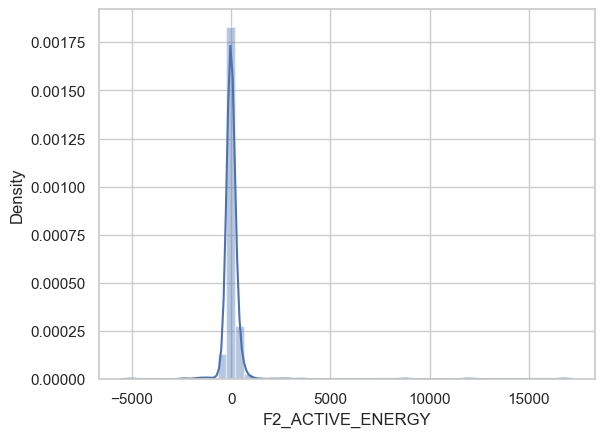

In [544]:
sns.distplot(error_2)
plt.show()

## Model for F3_ACTIVE_ENERGY

In [545]:
# Define the model
model_f_3 = XGBRegressor()

In [546]:
# Define the GridSearchCV object
grid_search_f3 = GridSearchCV(model_f_3, params, cv=kf, scoring='r2', n_jobs=-1)

In [547]:
X_f3 = final_consumption_dataframe.iloc[:, :-4]
y_f3 = final_consumption_dataframe['F3_ACTIVE_ENERGY']
X_train_f3, X_test_f3, y_train_f3, y_test_f3 = train_test_split(X_f3, y_f3, test_size=0.2, random_state=42)

In [548]:
# Fit the GridSearchCV object to the data
grid_search_f3.fit(X_train_f3, y_train_f3)



GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    int...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                 

In [549]:
# Print the best hyperparameters and the corresponding R-squared score
print("Best parameters: ", grid_search_f3.best_params_)
print("Best R-squared score: ", grid_search_f3.best_score_)



Best parameters:  {'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1}
Best R-squared score:  0.6661667100258446


In [550]:
# Extract the best model and use it to make predictions
best_model_f3 = grid_search_f3.best_estimator_
y_pred_f3 = best_model_f3.predict(X_test_f3)


In [551]:
# Calculate the R-squared score on the train data
r2_f3 = best_model_f3.score(X_test_f3, y_test_f3)
print("Testing R-squared score: ", r2_f3)

Testing R-squared score:  0.735362227580088


In [552]:
importance_scores_f3 = best_model_f3.feature_importances_
importance_scores_f3

array([7.59419752e-04, 2.97689298e-03, 5.61823584e-02, 1.12773571e-02,
       3.40468436e-03, 1.29681423e-01, 2.31585465e-03, 4.68239561e-02,
       1.31070940e-02, 4.87662368e-02, 5.31356893e-02, 7.04621151e-02,
       3.62042541e-04, 2.12896485e-02, 4.87950370e-02, 4.48754430e-02,
       1.09361429e-02, 2.00111070e-03, 2.57826236e-04, 5.46582155e-02,
       0.00000000e+00, 1.85591081e-04, 9.41004764e-05, 2.13589775e-03,
       8.62103794e-03, 2.19622540e-04, 2.22077128e-03, 0.00000000e+00,
       6.88017011e-02, 0.00000000e+00, 0.00000000e+00, 1.08250370e-03,
       2.66517326e-03, 0.00000000e+00, 2.10701418e-03, 1.13772496e-03,
       0.00000000e+00, 4.01114783e-04, 4.17210860e-04, 4.20106156e-03,
       4.57355141e-04, 1.76867202e-03, 5.32860542e-03, 1.39743253e-03,
       8.14385567e-05, 3.03682010e-03, 1.12996262e-03, 1.39505416e-01,
       1.59208209e-03, 1.50936260e-03, 3.69606307e-03, 1.24137655e-01],
      dtype=float32)

In [553]:
# Model errors for test

mse_test_f3 = mean_squared_error(y_test_f3, y_pred_f3)
mae_test_f3 = mean_absolute_error(y_test_f3, y_pred_f3)

print("MSE on test data: ", mse_test_f3)
print("MAE on test data: ", mae_test_f3)

MSE on test data:  1645133.7420106814
MAE on test data:  338.34900731244505


In [554]:
error_3 = y_test_f3-y_pred_f3

C:\Users\Chintu\AppData\Local\Temp\ipykernel_3440\1795982177.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error_3)


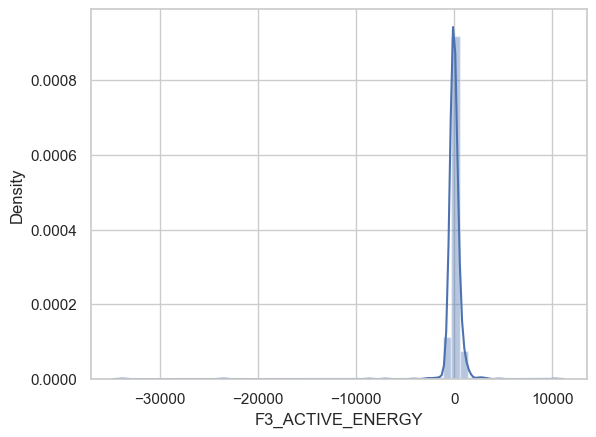

In [555]:
sns.distplot(error_3)
plt.show()

# Conclusions from the model.

1) r2_score values for F1, F2, F3 are 0.80, 0.83, 0.73 respectively. Comparing training and testing r2_scores, the model doesn't exhibit worrying differences indicating that it's neither overfit nor underfit.

2) Error plots show that errors are normally distributed implying that the model has a good generalisation of the data.

3) To improve the r2_score, many more trials can be made by manipulating the data. Also considering the very high number of columns(dimensionality), it is recommended to try dimensionality reduction techniques like PCA. 